##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.1 MB/s eta 0:00:00


In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

print("TF version:", tf.__version__)

tfds.disable_progress_bar()

TF version: 2.19.0


In [4]:
import keras

In [6]:
# Use Keras 2.
#version_fn = getattr(keras, "version", None)
#if version_fn and version_fn().startswith("3."):
#  import tf_keras as keras
#else:
#  keras = tf.keras

Import `matplotlib` and create a helper function to plot graphs:

In [7]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [8]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [9]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I rented this movie about 3 years ago, and it still stands out in my mind as the worst movie ever made. I don't think I ever finished it. It is worse than a home video made by a high school student. I remember them doing a flashback to 1970 something and in the flashback there was a man with a polo shirt, oakley sunglasses and a newer SUV, like a Toyota Rav-4 or something (I don't remember). I don't understand how they could have possibly said that to be in the 70s. He might have had a cell phone too, I cant remember, It was just horrible. I returned it to the video store and asked them why they even carry the movie and if I could get the hour of my life back. To this day it is the worst movie I have ever seen, and I have seen some pretty bad ones."
 b'Seriously. This is one of the most stupid family shows of all time.<br /><br />Plot- A family without a mother and 3 "dads" raise 3 little girls in San Francisco, California.<br /><br />Characters- Neat freak Danny, cartoon lo

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [13]:
VOCAB_SIZE = 1000
encoder = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [14]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [15]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,   1,  11, ...,   0,   0,   0],
       [632,  11,   7, ...,   0,   0,   0],
       [ 10, 373,  49, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [16]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I rented this movie about 3 years ago, and it still stands out in my mind as the worst movie ever made. I don't think I ever finished it. It is worse than a home video made by a high school student. I remember them doing a flashback to 1970 something and in the flashback there was a man with a polo shirt, oakley sunglasses and a newer SUV, like a Toyota Rav-4 or something (I don't remember). I don't understand how they could have possibly said that to be in the 70s. He might have had a cell phone too, I cant remember, It was just horrible. I returned it to the video store and asked them why they even carry the movie and if I could get the hour of my life back. To this day it is the worst movie I have ever seen, and I have seen some pretty bad ones."
Round-trip:  i [UNK] this movie about 3 years ago and it still [UNK] out in my mind as the worst movie ever made i dont think i ever [UNK] it it is worse than a home video made by a high school [UNK] i remember them doing a [UN

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [17]:
model = keras.Sequential([
    encoder,
    keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [18]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [19]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Convert to numpy array and cast to object dtype
input_array = np.array([sample_text]).astype(object)

#predictions = model.predict(np.array([sample_text]))
predictions = model.predict(input_array)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
[-0.00374835]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [20]:
# predict on a sample text with padding

padding = "the " * 2000

# Convert to numpy array and cast to object dtype
input_array = np.array([sample_text,padding]).astype(object)

#predictions = model.predict(np.array([sample_text, padding]))
predictions = model.predict(input_array)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
[-0.00374834]


Compile the Keras model to configure the training process:

In [21]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#Calculating carbon emissions during model training

In [ ]:
!pip install codecarbon
from codecarbon import EmissionsTracker

## Train the model

In [23]:
#start emissions tracking
tracker = EmissionsTracker()
tracker.start()

#Model training
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

#stop emissions tracking
emissions: float = tracker.stop()
print(f"Emissions during training: {emissions} kg CO2")

[codecarbon WARNING @ 00:03:24] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:03:24] [setup] RAM Tracking...
[codecarbon INFO @ 00:03:24] [setup] CPU Tracking...
[codecarbon WARNING @ 00:03:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 00:03:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 00:03:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 00:03:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:03:25] [setup] GPU Tracking...
[codecarbon INFO @ 00:03:25] No GPU found.
[codecarbon INFO @ 00:03:25] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Epoch 1/10
  8/391 ━━━━━━━━━━━━━━━━━━━━ 7:44 1s/step - accuracy: 0.4759 - loss: 0.6929

[codecarbon INFO @ 00:03:40] Energy consumed for RAM : 0.000209 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:03:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:03:40] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 00:03:40] 0.000386 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 7:29 1s/step - accuracy: 0.4822 - loss: 0.6929

[codecarbon INFO @ 00:03:55] Energy consumed for RAM : 0.000417 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:03:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:03:55] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 00:03:55] 0.000771 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 7:08 1s/step - accuracy: 0.4898 - loss: 0.6929

[codecarbon INFO @ 00:04:10] Energy consumed for RAM : 0.000625 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:04:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:04:10] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 00:04:10] 0.001157 kWh of electricity used since the beginning.


 45/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 1s/step - accuracy: 0.4916 - loss: 0.6929

[codecarbon INFO @ 00:04:25] Energy consumed for RAM : 0.000834 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:04:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:04:25] Energy consumed for All CPU : 0.000709 kWh
[codecarbon INFO @ 00:04:25] 0.001542 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 6:29 1s/step - accuracy: 0.4932 - loss: 0.6928

[codecarbon INFO @ 00:04:40] Energy consumed for RAM : 0.001042 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:04:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:04:40] Energy consumed for All CPU : 0.000886 kWh
[codecarbon INFO @ 00:04:40] 0.001927 kWh of electricity used since the beginning.


 71/391 ━━━━━━━━━━━━━━━━━━━━ 6:24 1s/step - accuracy: 0.4940 - loss: 0.6928

[codecarbon INFO @ 00:04:55] Energy consumed for RAM : 0.001250 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:04:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:04:55] Energy consumed for All CPU : 0.001063 kWh
[codecarbon INFO @ 00:04:55] 0.002313 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 6:05 1s/step - accuracy: 0.4943 - loss: 0.6928

[codecarbon INFO @ 00:05:10] Energy consumed for RAM : 0.001458 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:05:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:05:10] Energy consumed for All CPU : 0.001240 kWh
[codecarbon INFO @ 00:05:10] 0.002698 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 5:41 1s/step - accuracy: 0.4951 - loss: 0.6927

[codecarbon INFO @ 00:05:25] Energy consumed for RAM : 0.001667 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:05:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:05:25] Energy consumed for All CPU : 0.001417 kWh
[codecarbon INFO @ 00:05:25] 0.003084 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:05:25] 0.011628 g.CO2eq/s mean an estimation of 366.7035260103312 kg.CO2eq/year


112/391 ━━━━━━━━━━━━━━━━━━━━ 5:24 1s/step - accuracy: 0.4957 - loss: 0.6927

[codecarbon INFO @ 00:05:40] Energy consumed for RAM : 0.001875 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:05:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:05:40] Energy consumed for All CPU : 0.001594 kWh
[codecarbon INFO @ 00:05:40] 0.003469 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 5:06 1s/step - accuracy: 0.4965 - loss: 0.6926

[codecarbon INFO @ 00:05:55] Energy consumed for RAM : 0.002083 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:05:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:05:55] Energy consumed for All CPU : 0.001771 kWh
[codecarbon INFO @ 00:05:55] 0.003854 kWh of electricity used since the beginning.


138/391 ━━━━━━━━━━━━━━━━━━━━ 4:53 1s/step - accuracy: 0.4970 - loss: 0.6926

[codecarbon INFO @ 00:06:10] Energy consumed for RAM : 0.002292 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:06:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:06:10] Energy consumed for All CPU : 0.001948 kWh
[codecarbon INFO @ 00:06:10] 0.004240 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 4:38 1s/step - accuracy: 0.4974 - loss: 0.6926

[codecarbon INFO @ 00:06:25] Energy consumed for RAM : 0.002500 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:06:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:06:25] Energy consumed for All CPU : 0.002125 kWh
[codecarbon INFO @ 00:06:25] 0.004625 kWh of electricity used since the beginning.


164/391 ━━━━━━━━━━━━━━━━━━━━ 4:23 1s/step - accuracy: 0.4978 - loss: 0.6925

[codecarbon INFO @ 00:06:40] Energy consumed for RAM : 0.002708 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:06:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:06:40] Energy consumed for All CPU : 0.002302 kWh
[codecarbon INFO @ 00:06:40] 0.005010 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 4:06 1s/step - accuracy: 0.4983 - loss: 0.6924

[codecarbon INFO @ 00:06:55] Energy consumed for RAM : 0.002917 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:06:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:06:55] Energy consumed for All CPU : 0.002479 kWh
[codecarbon INFO @ 00:06:55] 0.005396 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 3:50 1s/step - accuracy: 0.4987 - loss: 0.6923

[codecarbon INFO @ 00:07:10] Energy consumed for RAM : 0.003125 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:07:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:07:10] Energy consumed for All CPU : 0.002656 kWh
[codecarbon INFO @ 00:07:10] 0.005781 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 3:35 1s/step - accuracy: 0.4989 - loss: 0.6922

[codecarbon INFO @ 00:07:25] Energy consumed for RAM : 0.003333 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:07:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:07:25] Energy consumed for All CPU : 0.002833 kWh
[codecarbon INFO @ 00:07:25] 0.006167 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:07:25] 0.011628 g.CO2eq/s mean an estimation of 366.70218413258755 kg.CO2eq/year


216/391 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - accuracy: 0.4991 - loss: 0.6919

[codecarbon INFO @ 00:07:40] Energy consumed for RAM : 0.003541 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:07:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:07:40] Energy consumed for All CPU : 0.003011 kWh
[codecarbon INFO @ 00:07:40] 0.006552 kWh of electricity used since the beginning.


227/391 ━━━━━━━━━━━━━━━━━━━━ 3:11 1s/step - accuracy: 0.4994 - loss: 0.6917

[codecarbon INFO @ 00:07:55] Energy consumed for RAM : 0.003750 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:07:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:07:55] Energy consumed for All CPU : 0.003188 kWh
[codecarbon INFO @ 00:07:55] 0.006937 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 2:54 1s/step - accuracy: 0.4997 - loss: 0.6917

[codecarbon INFO @ 00:08:10] Energy consumed for RAM : 0.003958 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:08:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:08:10] Energy consumed for All CPU : 0.003365 kWh
[codecarbon INFO @ 00:08:10] 0.007323 kWh of electricity used since the beginning.


252/391 ━━━━━━━━━━━━━━━━━━━━ 2:43 1s/step - accuracy: 0.4999 - loss: 0.6916

[codecarbon INFO @ 00:08:25] Energy consumed for RAM : 0.004166 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:08:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:08:25] Energy consumed for All CPU : 0.003542 kWh
[codecarbon INFO @ 00:08:25] 0.007708 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 1s/step - accuracy: 0.5001 - loss: 0.6915

[codecarbon INFO @ 00:08:40] Energy consumed for RAM : 0.004375 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:08:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:08:40] Energy consumed for All CPU : 0.003719 kWh
[codecarbon INFO @ 00:08:40] 0.008093 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 2:10 1s/step - accuracy: 0.5005 - loss: 0.6912

[codecarbon INFO @ 00:08:55] Energy consumed for RAM : 0.004583 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:08:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:08:55] Energy consumed for All CPU : 0.003896 kWh
[codecarbon INFO @ 00:08:55] 0.008479 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.5010 - loss: 0.6908

[codecarbon INFO @ 00:09:10] Energy consumed for RAM : 0.004791 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:09:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:09:10] Energy consumed for All CPU : 0.004073 kWh
[codecarbon INFO @ 00:09:10] 0.008864 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.5019 - loss: 0.6903

[codecarbon INFO @ 00:09:25] Energy consumed for RAM : 0.005000 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:09:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:09:25] Energy consumed for All CPU : 0.004250 kWh
[codecarbon INFO @ 00:09:25] 0.009250 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:09:25] 0.011628 g.CO2eq/s mean an estimation of 366.7080827448571 kg.CO2eq/year


319/391 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.5029 - loss: 0.6897

[codecarbon INFO @ 00:09:40] Energy consumed for RAM : 0.005208 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:09:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:09:40] Energy consumed for All CPU : 0.004427 kWh
[codecarbon INFO @ 00:09:40] 0.009635 kWh of electricity used since the beginning.


331/391 ━━━━━━━━━━━━━━━━━━━━ 1:09 1s/step - accuracy: 0.5040 - loss: 0.6891

[codecarbon INFO @ 00:09:55] Energy consumed for RAM : 0.005416 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:09:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:09:55] Energy consumed for All CPU : 0.004604 kWh
[codecarbon INFO @ 00:09:55] 0.010020 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5054 - loss: 0.6884

[codecarbon INFO @ 00:10:10] Energy consumed for RAM : 0.005624 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:10:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:10:10] Energy consumed for All CPU : 0.004781 kWh
[codecarbon INFO @ 00:10:10] 0.010406 kWh of electricity used since the beginning.


357/391 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5069 - loss: 0.6875

[codecarbon INFO @ 00:10:25] Energy consumed for RAM : 0.005833 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:10:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:10:25] Energy consumed for All CPU : 0.004958 kWh
[codecarbon INFO @ 00:10:25] 0.010791 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5085 - loss: 0.6866

[codecarbon INFO @ 00:10:40] Energy consumed for RAM : 0.006041 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:10:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:10:40] Energy consumed for All CPU : 0.005135 kWh
[codecarbon INFO @ 00:10:40] 0.011176 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5101 - loss: 0.6856 

[codecarbon INFO @ 00:10:55] Energy consumed for RAM : 0.006249 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:10:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:10:55] Energy consumed for All CPU : 0.005312 kWh
[codecarbon INFO @ 00:10:55] 0.011562 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5112 - loss: 0.6850

[codecarbon INFO @ 00:11:10] Energy consumed for RAM : 0.006458 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:11:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:11:10] Energy consumed for All CPU : 0.005490 kWh
[codecarbon INFO @ 00:11:10] 0.011947 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.5113 - loss: 0.6849 - val_accuracy: 0.7349 - val_loss: 0.5337
Epoch 2/10
 11/391 ━━━━━━━━━━━━━━━━━━━━ 7:51 1s/step - accuracy: 0.7444 - loss: 0.5234

[codecarbon INFO @ 00:11:25] Energy consumed for RAM : 0.006666 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:11:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:11:25] Energy consumed for All CPU : 0.005667 kWh
[codecarbon INFO @ 00:11:25] 0.012333 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:11:25] 0.011628 g.CO2eq/s mean an estimation of 366.7107918780141 kg.CO2eq/year


 24/391 ━━━━━━━━━━━━━━━━━━━━ 7:07 1s/step - accuracy: 0.7556 - loss: 0.5142

[codecarbon INFO @ 00:11:40] Energy consumed for RAM : 0.006874 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:11:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:11:40] Energy consumed for All CPU : 0.005844 kWh
[codecarbon INFO @ 00:11:40] 0.012718 kWh of electricity used since the beginning.


 38/391 ━━━━━━━━━━━━━━━━━━━━ 6:38 1s/step - accuracy: 0.7625 - loss: 0.5090

[codecarbon INFO @ 00:11:55] Energy consumed for RAM : 0.007083 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:11:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:11:55] Energy consumed for All CPU : 0.006021 kWh
[codecarbon INFO @ 00:11:55] 0.013103 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 1s/step - accuracy: 0.7676 - loss: 0.5045

[codecarbon INFO @ 00:12:10] Energy consumed for RAM : 0.007291 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:12:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:12:10] Energy consumed for All CPU : 0.006198 kWh
[codecarbon INFO @ 00:12:10] 0.013489 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 6:06 1s/step - accuracy: 0.7708 - loss: 0.5017

[codecarbon INFO @ 00:12:25] Energy consumed for RAM : 0.007499 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:12:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:12:25] Energy consumed for All CPU : 0.006375 kWh
[codecarbon INFO @ 00:12:25] 0.013874 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 5:48 1s/step - accuracy: 0.7725 - loss: 0.4992

[codecarbon INFO @ 00:12:40] Energy consumed for RAM : 0.007708 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:12:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:12:40] Energy consumed for All CPU : 0.006552 kWh
[codecarbon INFO @ 00:12:40] 0.014259 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 5:31 1s/step - accuracy: 0.7738 - loss: 0.4969

[codecarbon INFO @ 00:12:55] Energy consumed for RAM : 0.007916 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:12:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:12:55] Energy consumed for All CPU : 0.006729 kWh
[codecarbon INFO @ 00:12:55] 0.014645 kWh of electricity used since the beginning.


106/391 ━━━━━━━━━━━━━━━━━━━━ 5:16 1s/step - accuracy: 0.7749 - loss: 0.4947

[codecarbon INFO @ 00:13:10] Energy consumed for RAM : 0.008124 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:13:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:13:10] Energy consumed for All CPU : 0.006906 kWh
[codecarbon INFO @ 00:13:10] 0.015030 kWh of electricity used since the beginning.


120/391 ━━━━━━━━━━━━━━━━━━━━ 5:01 1s/step - accuracy: 0.7761 - loss: 0.4925

[codecarbon INFO @ 00:13:25] Energy consumed for RAM : 0.008332 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:13:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:13:25] Energy consumed for All CPU : 0.007083 kWh
[codecarbon INFO @ 00:13:25] 0.015416 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:13:25] 0.011628 g.CO2eq/s mean an estimation of 366.7077820855535 kg.CO2eq/year


132/391 ━━━━━━━━━━━━━━━━━━━━ 4:50 1s/step - accuracy: 0.7770 - loss: 0.4906

[codecarbon INFO @ 00:13:40] Energy consumed for RAM : 0.008541 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:13:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:13:40] Energy consumed for All CPU : 0.007260 kWh
[codecarbon INFO @ 00:13:40] 0.015801 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 1s/step - accuracy: 0.7783 - loss: 0.4881

[codecarbon INFO @ 00:13:55] Energy consumed for RAM : 0.008749 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:13:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:13:55] Energy consumed for All CPU : 0.007437 kWh
[codecarbon INFO @ 00:13:55] 0.016186 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 4:15 1s/step - accuracy: 0.7794 - loss: 0.4858

[codecarbon INFO @ 00:14:10] Energy consumed for RAM : 0.008957 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:14:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:14:10] Energy consumed for All CPU : 0.007614 kWh
[codecarbon INFO @ 00:14:10] 0.016572 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 4:01 1s/step - accuracy: 0.7804 - loss: 0.4838

[codecarbon INFO @ 00:14:25] Energy consumed for RAM : 0.009166 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:14:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:14:25] Energy consumed for All CPU : 0.007791 kWh
[codecarbon INFO @ 00:14:25] 0.016957 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 1s/step - accuracy: 0.7813 - loss: 0.4819

[codecarbon INFO @ 00:14:40] Energy consumed for RAM : 0.009374 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:14:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:14:40] Energy consumed for All CPU : 0.007969 kWh
[codecarbon INFO @ 00:14:40] 0.017342 kWh of electricity used since the beginning.


199/391 ━━━━━━━━━━━━━━━━━━━━ 3:34 1s/step - accuracy: 0.7821 - loss: 0.4801

[codecarbon INFO @ 00:14:55] Energy consumed for RAM : 0.009582 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:14:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


200/391 ━━━━━━━━━━━━━━━━━━━━ 3:33 1s/step - accuracy: 0.7821 - loss: 0.4800

[codecarbon INFO @ 00:14:55] Energy consumed for All CPU : 0.008146 kWh
[codecarbon INFO @ 00:14:55] 0.017728 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 3:19 1s/step - accuracy: 0.7829 - loss: 0.4781

[codecarbon INFO @ 00:15:10] Energy consumed for RAM : 0.009790 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:15:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:15:10] Energy consumed for All CPU : 0.008323 kWh
[codecarbon INFO @ 00:15:10] 0.018113 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 3:01 1s/step - accuracy: 0.7838 - loss: 0.4760

[codecarbon INFO @ 00:15:25] Energy consumed for RAM : 0.009999 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:15:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:15:25] Energy consumed for All CPU : 0.008500 kWh
[codecarbon INFO @ 00:15:25] 0.018498 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:15:25] 0.011628 g.CO2eq/s mean an estimation of 366.693937736774 kg.CO2eq/year


239/391 ━━━━━━━━━━━━━━━━━━━━ 2:50 1s/step - accuracy: 0.7844 - loss: 0.4745

[codecarbon INFO @ 00:15:40] Energy consumed for RAM : 0.010207 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:15:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:15:40] Energy consumed for All CPU : 0.008677 kWh
[codecarbon INFO @ 00:15:40] 0.018884 kWh of electricity used since the beginning.


252/391 ━━━━━━━━━━━━━━━━━━━━ 2:36 1s/step - accuracy: 0.7851 - loss: 0.4729

[codecarbon INFO @ 00:15:55] Energy consumed for RAM : 0.010415 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:15:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:15:55] Energy consumed for All CPU : 0.008854 kWh
[codecarbon INFO @ 00:15:55] 0.019269 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 2:25 1s/step - accuracy: 0.7856 - loss: 0.4716

[codecarbon INFO @ 00:16:10] Energy consumed for RAM : 0.010624 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:16:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:16:10] Energy consumed for All CPU : 0.009031 kWh
[codecarbon INFO @ 00:16:10] 0.019655 kWh of electricity used since the beginning.


275/391 ━━━━━━━━━━━━━━━━━━━━ 2:11 1s/step - accuracy: 0.7862 - loss: 0.4701

[codecarbon INFO @ 00:16:25] Energy consumed for RAM : 0.010832 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:16:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:16:25] Energy consumed for All CPU : 0.009208 kWh
[codecarbon INFO @ 00:16:25] 0.020040 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.7869 - loss: 0.4684

[codecarbon INFO @ 00:16:40] Energy consumed for RAM : 0.011039 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:16:40] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:16:40] Energy consumed for All CPU : 0.009384 kWh
[codecarbon INFO @ 00:16:40] 0.020423 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.7875 - loss: 0.4670

[codecarbon INFO @ 00:16:55] Energy consumed for RAM : 0.011248 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:16:55] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 00:16:55] Energy consumed for All CPU : 0.009562 kWh
[codecarbon INFO @ 00:16:55] 0.020810 kWh of electricity used since the beginning.


313/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - accuracy: 0.7881 - loss: 0.4656

[codecarbon INFO @ 00:17:10] Energy consumed for RAM : 0.011455 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:17:10] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:17:10] Energy consumed for All CPU : 0.009738 kWh
[codecarbon INFO @ 00:17:10] 0.021193 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:14 1s/step - accuracy: 0.7887 - loss: 0.4641

[codecarbon INFO @ 00:17:25] Energy consumed for RAM : 0.011663 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:17:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:17:25] Energy consumed for All CPU : 0.009915 kWh
[codecarbon INFO @ 00:17:25] 0.021578 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:17:25] 0.011617 g.CO2eq/s mean an estimation of 366.35467893300336 kg.CO2eq/year


340/391 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7893 - loss: 0.4627

[codecarbon INFO @ 00:17:40] Energy consumed for RAM : 0.011871 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:17:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:17:40] Energy consumed for All CPU : 0.010092 kWh
[codecarbon INFO @ 00:17:40] 0.021964 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7899 - loss: 0.4613

[codecarbon INFO @ 00:17:55] Energy consumed for RAM : 0.012080 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:17:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:17:55] Energy consumed for All CPU : 0.010270 kWh
[codecarbon INFO @ 00:17:55] 0.022349 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7905 - loss: 0.4599

[codecarbon INFO @ 00:18:10] Energy consumed for RAM : 0.012288 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:18:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:18:10] Energy consumed for All CPU : 0.010447 kWh
[codecarbon INFO @ 00:18:10] 0.022735 kWh of electricity used since the beginning.


377/391 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7909 - loss: 0.4589

[codecarbon INFO @ 00:18:25] Energy consumed for RAM : 0.012496 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:18:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:18:25] Energy consumed for All CPU : 0.010624 kWh
[codecarbon INFO @ 00:18:25] 0.023120 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7915 - loss: 0.4576

[codecarbon INFO @ 00:18:40] Energy consumed for RAM : 0.012705 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:18:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:18:40] Energy consumed for All CPU : 0.010801 kWh
[codecarbon INFO @ 00:18:40] 0.023505 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.7916 - loss: 0.4574 - val_accuracy: 0.8391 - val_loss: 0.3697
Epoch 3/10
  7/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 1s/step - accuracy: 0.8725 - loss: 0.3446

[codecarbon INFO @ 00:18:55] Energy consumed for RAM : 0.012913 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:18:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:18:55] Energy consumed for All CPU : 0.010978 kWh
[codecarbon INFO @ 00:18:55] 0.023891 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 6:25 1s/step - accuracy: 0.8566 - loss: 0.3555

[codecarbon INFO @ 00:19:10] Energy consumed for RAM : 0.013121 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:19:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:19:10] Energy consumed for All CPU : 0.011155 kWh
[codecarbon INFO @ 00:19:10] 0.024276 kWh of electricity used since the beginning.


 35/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 1s/step - accuracy: 0.8504 - loss: 0.3631

[codecarbon INFO @ 00:19:25] Energy consumed for RAM : 0.013329 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:19:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:19:25] Energy consumed for All CPU : 0.011332 kWh
[codecarbon INFO @ 00:19:25] 0.024661 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:19:25] 0.011628 g.CO2eq/s mean an estimation of 366.703868492995 kg.CO2eq/year


 49/391 ━━━━━━━━━━━━━━━━━━━━ 6:09 1s/step - accuracy: 0.8448 - loss: 0.3685

[codecarbon INFO @ 00:19:40] Energy consumed for RAM : 0.013538 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:19:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:19:40] Energy consumed for All CPU : 0.011509 kWh
[codecarbon INFO @ 00:19:40] 0.025047 kWh of electricity used since the beginning.


 62/391 ━━━━━━━━━━━━━━━━━━━━ 6:01 1s/step - accuracy: 0.8420 - loss: 0.3700

[codecarbon INFO @ 00:19:55] Energy consumed for RAM : 0.013746 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:19:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:19:55] Energy consumed for All CPU : 0.011686 kWh
[codecarbon INFO @ 00:19:55] 0.025432 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 5:49 1s/step - accuracy: 0.8407 - loss: 0.3703

[codecarbon INFO @ 00:20:10] Energy consumed for RAM : 0.013954 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:20:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:20:10] Energy consumed for All CPU : 0.011863 kWh
[codecarbon INFO @ 00:20:10] 0.025818 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 5:38 1s/step - accuracy: 0.8397 - loss: 0.3703

[codecarbon INFO @ 00:20:25] Energy consumed for RAM : 0.014163 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:20:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:20:25] Energy consumed for All CPU : 0.012040 kWh
[codecarbon INFO @ 00:20:25] 0.026203 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 5:21 1s/step - accuracy: 0.8388 - loss: 0.3703

[codecarbon INFO @ 00:20:40] Energy consumed for RAM : 0.014371 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:20:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:20:40] Energy consumed for All CPU : 0.012217 kWh
[codecarbon INFO @ 00:20:40] 0.026588 kWh of electricity used since the beginning.


115/391 ━━━━━━━━━━━━━━━━━━━━ 5:07 1s/step - accuracy: 0.8382 - loss: 0.3699

[codecarbon INFO @ 00:20:55] Energy consumed for RAM : 0.014579 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:20:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:20:55] Energy consumed for All CPU : 0.012394 kWh
[codecarbon INFO @ 00:20:55] 0.026974 kWh of electricity used since the beginning.


128/391 ━━━━━━━━━━━━━━━━━━━━ 4:54 1s/step - accuracy: 0.8378 - loss: 0.3693

[codecarbon INFO @ 00:21:10] Energy consumed for RAM : 0.014788 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:21:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:21:10] Energy consumed for All CPU : 0.012571 kWh
[codecarbon INFO @ 00:21:10] 0.027359 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 4:36 1s/step - accuracy: 0.8374 - loss: 0.3689

[codecarbon INFO @ 00:21:25] Energy consumed for RAM : 0.014996 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:21:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:21:25] Energy consumed for All CPU : 0.012749 kWh
[codecarbon INFO @ 00:21:25] 0.027744 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:21:25] 0.011628 g.CO2eq/s mean an estimation of 366.7132452438828 kg.CO2eq/year


155/391 ━━━━━━━━━━━━━━━━━━━━ 4:21 1s/step - accuracy: 0.8371 - loss: 0.3688

[codecarbon INFO @ 00:21:40] Energy consumed for RAM : 0.015204 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:21:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:21:40] Energy consumed for All CPU : 0.012926 kWh
[codecarbon INFO @ 00:21:40] 0.028130 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 4:17 1s/step - accuracy: 0.8369 - loss: 0.3686

[codecarbon INFO @ 00:21:55] Energy consumed for RAM : 0.015413 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:21:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:21:55] Energy consumed for All CPU : 0.013103 kWh
[codecarbon INFO @ 00:21:55] 0.028515 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 1s/step - accuracy: 0.8366 - loss: 0.3685

[codecarbon INFO @ 00:22:10] Energy consumed for RAM : 0.015621 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:22:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:22:10] Energy consumed for All CPU : 0.013280 kWh
[codecarbon INFO @ 00:22:10] 0.028901 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 1s/step - accuracy: 0.8365 - loss: 0.3682

[codecarbon INFO @ 00:22:25] Energy consumed for RAM : 0.015830 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:22:25] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 00:22:25] Energy consumed for All CPU : 0.013458 kWh
[codecarbon INFO @ 00:22:25] 0.029288 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 3:32 1s/step - accuracy: 0.8365 - loss: 0.3678

[codecarbon INFO @ 00:22:40] Energy consumed for RAM : 0.016038 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:22:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:22:40] Energy consumed for All CPU : 0.013635 kWh
[codecarbon INFO @ 00:22:40] 0.029673 kWh of electricity used since the beginning.


218/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 1s/step - accuracy: 0.8365 - loss: 0.3674

[codecarbon INFO @ 00:22:55] Energy consumed for RAM : 0.016247 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:22:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:22:55] Energy consumed for All CPU : 0.013812 kWh
[codecarbon INFO @ 00:22:55] 0.030058 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 3:01 1s/step - accuracy: 0.8366 - loss: 0.3670

[codecarbon INFO @ 00:23:10] Energy consumed for RAM : 0.016455 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:23:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:23:10] Energy consumed for All CPU : 0.013989 kWh
[codecarbon INFO @ 00:23:10] 0.030444 kWh of electricity used since the beginning.


245/391 ━━━━━━━━━━━━━━━━━━━━ 2:45 1s/step - accuracy: 0.8367 - loss: 0.3666

[codecarbon INFO @ 00:23:25] Energy consumed for RAM : 0.016663 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:23:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:23:25] Energy consumed for All CPU : 0.014166 kWh
[codecarbon INFO @ 00:23:25] 0.030829 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:23:25] 0.011628 g.CO2eq/s mean an estimation of 366.69866178058845 kg.CO2eq/year


258/391 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - accuracy: 0.8368 - loss: 0.3662

[codecarbon INFO @ 00:23:40] Energy consumed for RAM : 0.016871 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:23:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:23:40] Energy consumed for All CPU : 0.014343 kWh
[codecarbon INFO @ 00:23:40] 0.031214 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 2:15 1s/step - accuracy: 0.8368 - loss: 0.3658

[codecarbon INFO @ 00:23:55] Energy consumed for RAM : 0.017080 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:23:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:23:55] Energy consumed for All CPU : 0.014520 kWh
[codecarbon INFO @ 00:23:55] 0.031600 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 1:59 1s/step - accuracy: 0.8370 - loss: 0.3654

[codecarbon INFO @ 00:24:10] Energy consumed for RAM : 0.017288 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:24:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:24:10] Energy consumed for All CPU : 0.014697 kWh
[codecarbon INFO @ 00:24:10] 0.031985 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.8370 - loss: 0.3650

[codecarbon INFO @ 00:24:25] Energy consumed for RAM : 0.017496 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:24:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:24:25] Energy consumed for All CPU : 0.014874 kWh
[codecarbon INFO @ 00:24:25] 0.032371 kWh of electricity used since the beginning.


310/391 ━━━━━━━━━━━━━━━━━━━━ 1:32 1s/step - accuracy: 0.8372 - loss: 0.3646

[codecarbon INFO @ 00:24:40] Energy consumed for RAM : 0.017705 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:24:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:24:40] Energy consumed for All CPU : 0.015051 kWh
[codecarbon INFO @ 00:24:40] 0.032756 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - accuracy: 0.8373 - loss: 0.3642

[codecarbon INFO @ 00:24:55] Energy consumed for RAM : 0.017913 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:24:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:24:55] Energy consumed for All CPU : 0.015228 kWh
[codecarbon INFO @ 00:24:55] 0.033141 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.8375 - loss: 0.3637

[codecarbon INFO @ 00:25:10] Energy consumed for RAM : 0.018121 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:25:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:25:10] Energy consumed for All CPU : 0.015405 kWh
[codecarbon INFO @ 00:25:10] 0.033527 kWh of electricity used since the beginning.


350/391 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8377 - loss: 0.3633

[codecarbon INFO @ 00:25:25] Energy consumed for RAM : 0.018330 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:25:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:25:25] Energy consumed for All CPU : 0.015582 kWh
[codecarbon INFO @ 00:25:25] 0.033912 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:25:25] 0.011628 g.CO2eq/s mean an estimation of 366.7085111291803 kg.CO2eq/year


363/391 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8378 - loss: 0.3629

[codecarbon INFO @ 00:25:40] Energy consumed for RAM : 0.018538 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:25:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:25:40] Energy consumed for All CPU : 0.015760 kWh
[codecarbon INFO @ 00:25:40] 0.034297 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8380 - loss: 0.3624

[codecarbon INFO @ 00:25:55] Energy consumed for RAM : 0.018746 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:25:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:25:55] Energy consumed for All CPU : 0.015937 kWh
[codecarbon INFO @ 00:25:55] 0.034683 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8383 - loss: 0.3619

[codecarbon INFO @ 00:26:10] Energy consumed for RAM : 0.018955 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:26:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:26:10] Energy consumed for All CPU : 0.016114 kWh
[codecarbon INFO @ 00:26:10] 0.035068 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accuracy: 0.8383 - loss: 0.3619 - val_accuracy: 0.8510 - val_loss: 0.3608
Epoch 4/10
  6/391 ━━━━━━━━━━━━━━━━━━━━ 7:26 1s/step - accuracy: 0.8489 - loss: 0.3677

[codecarbon INFO @ 00:26:25] Energy consumed for RAM : 0.019163 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:26:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:26:25] Energy consumed for All CPU : 0.016291 kWh
[codecarbon INFO @ 00:26:25] 0.035454 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 7:07 1s/step - accuracy: 0.8409 - loss: 0.3735

[codecarbon INFO @ 00:26:40] Energy consumed for RAM : 0.019371 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:26:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:26:40] Energy consumed for All CPU : 0.016468 kWh
[codecarbon INFO @ 00:26:40] 0.035839 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 6:40 1s/step - accuracy: 0.8455 - loss: 0.3672

[codecarbon INFO @ 00:26:55] Energy consumed for RAM : 0.019579 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:26:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:26:55] Energy consumed for All CPU : 0.016645 kWh
[codecarbon INFO @ 00:26:55] 0.036224 kWh of electricity used since the beginning.


 48/391 ━━━━━━━━━━━━━━━━━━━━ 6:16 1s/step - accuracy: 0.8510 - loss: 0.3583

[codecarbon INFO @ 00:27:10] Energy consumed for RAM : 0.019788 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:27:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:27:10] Energy consumed for All CPU : 0.016822 kWh
[codecarbon INFO @ 00:27:10] 0.036610 kWh of electricity used since the beginning.


 61/391 ━━━━━━━━━━━━━━━━━━━━ 6:04 1s/step - accuracy: 0.8531 - loss: 0.3540

[codecarbon INFO @ 00:27:25] Energy consumed for RAM : 0.019996 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:27:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:27:25] Energy consumed for All CPU : 0.016999 kWh
[codecarbon INFO @ 00:27:25] 0.036995 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:27:25] 0.011628 g.CO2eq/s mean an estimation of 366.71097936906375 kg.CO2eq/year


 74/391 ━━━━━━━━━━━━━━━━━━━━ 5:52 1s/step - accuracy: 0.8548 - loss: 0.3503

[codecarbon INFO @ 00:27:40] Energy consumed for RAM : 0.020204 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:27:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:27:40] Energy consumed for All CPU : 0.017176 kWh
[codecarbon INFO @ 00:27:40] 0.037380 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 5:36 1s/step - accuracy: 0.8558 - loss: 0.3473

[codecarbon INFO @ 00:27:55] Energy consumed for RAM : 0.020413 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:27:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:27:55] Energy consumed for All CPU : 0.017353 kWh
[codecarbon INFO @ 00:27:55] 0.037766 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 5:19 1s/step - accuracy: 0.8564 - loss: 0.3448

[codecarbon INFO @ 00:28:10] Energy consumed for RAM : 0.020621 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:28:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:28:10] Energy consumed for All CPU : 0.017530 kWh
[codecarbon INFO @ 00:28:10] 0.038151 kWh of electricity used since the beginning.


115/391 ━━━━━━━━━━━━━━━━━━━━ 5:05 1s/step - accuracy: 0.8567 - loss: 0.3428

[codecarbon INFO @ 00:28:25] Energy consumed for RAM : 0.020829 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:28:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:28:25] Energy consumed for All CPU : 0.017707 kWh
[codecarbon INFO @ 00:28:25] 0.038537 kWh of electricity used since the beginning.


129/391 ━━━━━━━━━━━━━━━━━━━━ 4:49 1s/step - accuracy: 0.8569 - loss: 0.3411

[codecarbon INFO @ 00:28:40] Energy consumed for RAM : 0.021038 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:28:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:28:40] Energy consumed for All CPU : 0.017884 kWh
[codecarbon INFO @ 00:28:40] 0.038922 kWh of electricity used since the beginning.


141/391 ━━━━━━━━━━━━━━━━━━━━ 4:40 1s/step - accuracy: 0.8570 - loss: 0.3400

[codecarbon INFO @ 00:28:55] Energy consumed for RAM : 0.021246 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:28:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:28:55] Energy consumed for All CPU : 0.018061 kWh
[codecarbon INFO @ 00:28:55] 0.039307 kWh of electricity used since the beginning.


153/391 ━━━━━━━━━━━━━━━━━━━━ 4:26 1s/step - accuracy: 0.8571 - loss: 0.3391

[codecarbon INFO @ 00:29:10] Energy consumed for RAM : 0.021454 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:29:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:29:10] Energy consumed for All CPU : 0.018239 kWh
[codecarbon INFO @ 00:29:10] 0.039693 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 4:09 1s/step - accuracy: 0.8572 - loss: 0.3381

[codecarbon INFO @ 00:29:25] Energy consumed for RAM : 0.021662 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:29:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:29:25] Energy consumed for All CPU : 0.018416 kWh
[codecarbon INFO @ 00:29:25] 0.040078 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:29:25] 0.011628 g.CO2eq/s mean an estimation of 366.7002134784819 kg.CO2eq/year


183/391 ━━━━━━━━━━━━━━━━━━━━ 3:50 1s/step - accuracy: 0.8571 - loss: 0.3375

[codecarbon INFO @ 00:29:40] Energy consumed for RAM : 0.021871 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:29:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:29:40] Energy consumed for All CPU : 0.018593 kWh
[codecarbon INFO @ 00:29:40] 0.040463 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 3:38 1s/step - accuracy: 0.8569 - loss: 0.3372

[codecarbon INFO @ 00:29:55] Energy consumed for RAM : 0.022079 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:29:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:29:55] Energy consumed for All CPU : 0.018770 kWh
[codecarbon INFO @ 00:29:55] 0.040849 kWh of electricity used since the beginning.


209/391 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - accuracy: 0.8568 - loss: 0.3370

[codecarbon INFO @ 00:30:10] Energy consumed for RAM : 0.022287 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:30:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:30:10] Energy consumed for All CPU : 0.018947 kWh
[codecarbon INFO @ 00:30:10] 0.041234 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 3:04 1s/step - accuracy: 0.8566 - loss: 0.3367

[codecarbon INFO @ 00:30:25] Energy consumed for RAM : 0.022496 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:30:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:30:25] Energy consumed for All CPU : 0.019124 kWh
[codecarbon INFO @ 00:30:25] 0.041620 kWh of electricity used since the beginning.


238/391 ━━━━━━━━━━━━━━━━━━━━ 2:49 1s/step - accuracy: 0.8565 - loss: 0.3366

[codecarbon INFO @ 00:30:40] Energy consumed for RAM : 0.022704 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:30:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:30:40] Energy consumed for All CPU : 0.019301 kWh
[codecarbon INFO @ 00:30:40] 0.042005 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 2:37 1s/step - accuracy: 0.8564 - loss: 0.3365

[codecarbon INFO @ 00:30:55] Energy consumed for RAM : 0.022912 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:30:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:30:55] Energy consumed for All CPU : 0.019478 kWh
[codecarbon INFO @ 00:30:55] 0.042390 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 2:23 1s/step - accuracy: 0.8563 - loss: 0.3363

[codecarbon INFO @ 00:31:10] Energy consumed for RAM : 0.023121 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:31:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:31:10] Energy consumed for All CPU : 0.019655 kWh
[codecarbon INFO @ 00:31:10] 0.042776 kWh of electricity used since the beginning.


277/391 ━━━━━━━━━━━━━━━━━━━━ 2:06 1s/step - accuracy: 0.8563 - loss: 0.3361

[codecarbon INFO @ 00:31:25] Energy consumed for RAM : 0.023329 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:31:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:31:25] Energy consumed for All CPU : 0.019832 kWh
[codecarbon INFO @ 00:31:25] 0.043161 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:31:25] 0.011628 g.CO2eq/s mean an estimation of 366.7082075572276 kg.CO2eq/year


290/391 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.8562 - loss: 0.3360

[codecarbon INFO @ 00:31:40] Energy consumed for RAM : 0.023537 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:31:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:31:40] Energy consumed for All CPU : 0.020009 kWh
[codecarbon INFO @ 00:31:40] 0.043546 kWh of electricity used since the beginning.


304/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 1s/step - accuracy: 0.8561 - loss: 0.3359

[codecarbon INFO @ 00:31:55] Energy consumed for RAM : 0.023745 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:31:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:31:55] Energy consumed for All CPU : 0.020186 kWh
[codecarbon INFO @ 00:31:55] 0.043932 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 1:22 1s/step - accuracy: 0.8561 - loss: 0.3358

[codecarbon INFO @ 00:32:10] Energy consumed for RAM : 0.023954 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:32:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:32:10] Energy consumed for All CPU : 0.020363 kWh
[codecarbon INFO @ 00:32:10] 0.044317 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.8561 - loss: 0.3357

[codecarbon INFO @ 00:32:25] Energy consumed for RAM : 0.024162 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:32:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:32:25] Energy consumed for All CPU : 0.020540 kWh
[codecarbon INFO @ 00:32:25] 0.044703 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8561 - loss: 0.3356

[codecarbon INFO @ 00:32:40] Energy consumed for RAM : 0.024370 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:32:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:32:40] Energy consumed for All CPU : 0.020718 kWh
[codecarbon INFO @ 00:32:40] 0.045088 kWh of electricity used since the beginning.


357/391 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8561 - loss: 0.3355

[codecarbon INFO @ 00:32:55] Energy consumed for RAM : 0.024579 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:32:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:32:55] Energy consumed for All CPU : 0.020895 kWh
[codecarbon INFO @ 00:32:55] 0.045473 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8561 - loss: 0.3354

[codecarbon INFO @ 00:33:10] Energy consumed for RAM : 0.024787 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:33:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:33:10] Energy consumed for All CPU : 0.021072 kWh
[codecarbon INFO @ 00:33:10] 0.045859 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8561 - loss: 0.3353

[codecarbon INFO @ 00:33:25] Energy consumed for RAM : 0.024995 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:33:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:33:25] Energy consumed for All CPU : 0.021249 kWh
[codecarbon INFO @ 00:33:25] 0.046244 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:33:25] 0.011628 g.CO2eq/s mean an estimation of 366.698087021828 kg.CO2eq/year


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8561 - loss: 0.3351

[codecarbon INFO @ 00:33:40] Energy consumed for RAM : 0.025204 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:33:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:33:40] Energy consumed for All CPU : 0.021426 kWh
[codecarbon INFO @ 00:33:40] 0.046629 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.8561 - loss: 0.3351 - val_accuracy: 0.8458 - val_loss: 0.3345
Epoch 5/10
  6/391 ━━━━━━━━━━━━━━━━━━━━ 8:28 1s/step - accuracy: 0.8630 - loss: 0.3105

[codecarbon INFO @ 00:33:55] Energy consumed for RAM : 0.025412 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:33:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:33:55] Energy consumed for All CPU : 0.021603 kWh
[codecarbon INFO @ 00:33:55] 0.047015 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 7:44 1s/step - accuracy: 0.8608 - loss: 0.2992

[codecarbon INFO @ 00:34:10] Energy consumed for RAM : 0.025620 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:34:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:34:10] Energy consumed for All CPU : 0.021780 kWh
[codecarbon INFO @ 00:34:10] 0.047400 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 7:07 1s/step - accuracy: 0.8591 - loss: 0.2991

[codecarbon INFO @ 00:34:25] Energy consumed for RAM : 0.025828 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:34:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:34:25] Energy consumed for All CPU : 0.021957 kWh
[codecarbon INFO @ 00:34:25] 0.047786 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 6:48 1s/step - accuracy: 0.8573 - loss: 0.3020

[codecarbon INFO @ 00:34:40] Energy consumed for RAM : 0.026037 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:34:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:34:40] Energy consumed for All CPU : 0.022134 kWh
[codecarbon INFO @ 00:34:40] 0.048171 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 6:43 1s/step - accuracy: 0.8556 - loss: 0.3075

[codecarbon INFO @ 00:34:55] Energy consumed for RAM : 0.026245 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:34:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:34:55] Energy consumed for All CPU : 0.022311 kWh
[codecarbon INFO @ 00:34:55] 0.048556 kWh of electricity used since the beginning.


 71/391 ━━━━━━━━━━━━━━━━━━━━ 6:18 1s/step - accuracy: 0.8544 - loss: 0.3114

[codecarbon INFO @ 00:35:10] Energy consumed for RAM : 0.026453 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:35:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:35:10] Energy consumed for All CPU : 0.022488 kWh
[codecarbon INFO @ 00:35:10] 0.048942 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 6:08 1s/step - accuracy: 0.8537 - loss: 0.3135

[codecarbon INFO @ 00:35:25] Energy consumed for RAM : 0.026662 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:35:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:35:25] Energy consumed for All CPU : 0.022665 kWh
[codecarbon INFO @ 00:35:25] 0.049327 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:35:25] 0.011628 g.CO2eq/s mean an estimation of 366.70865134605214 kg.CO2eq/year


 97/391 ━━━━━━━━━━━━━━━━━━━━ 5:44 1s/step - accuracy: 0.8536 - loss: 0.3149

[codecarbon INFO @ 00:35:40] Energy consumed for RAM : 0.026870 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:35:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:35:40] Energy consumed for All CPU : 0.022842 kWh
[codecarbon INFO @ 00:35:40] 0.049712 kWh of electricity used since the beginning.


110/391 ━━━━━━━━━━━━━━━━━━━━ 5:27 1s/step - accuracy: 0.8535 - loss: 0.3160

[codecarbon INFO @ 00:35:55] Energy consumed for RAM : 0.027078 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:35:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:35:55] Energy consumed for All CPU : 0.023019 kWh
[codecarbon INFO @ 00:35:55] 0.050098 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 5:11 1s/step - accuracy: 0.8536 - loss: 0.3170

[codecarbon INFO @ 00:36:10] Energy consumed for RAM : 0.027287 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:36:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:36:10] Energy consumed for All CPU : 0.023197 kWh
[codecarbon INFO @ 00:36:10] 0.050483 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 4:54 1s/step - accuracy: 0.8536 - loss: 0.3180

[codecarbon INFO @ 00:36:25] Energy consumed for RAM : 0.027495 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:36:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:36:25] Energy consumed for All CPU : 0.023374 kWh
[codecarbon INFO @ 00:36:25] 0.050869 kWh of electricity used since the beginning.


152/391 ━━━━━━━━━━━━━━━━━━━━ 4:33 1s/step - accuracy: 0.8536 - loss: 0.3189

[codecarbon INFO @ 00:36:41] Energy consumed for RAM : 0.027704 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:36:41] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 00:36:41] Energy consumed for All CPU : 0.023552 kWh
[codecarbon INFO @ 00:36:41] 0.051256 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 4:18 1s/step - accuracy: 0.8536 - loss: 0.3195

[codecarbon INFO @ 00:36:56] Energy consumed for RAM : 0.027912 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:36:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:36:56] Energy consumed for All CPU : 0.023729 kWh
[codecarbon INFO @ 00:36:56] 0.051641 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 1s/step - accuracy: 0.8535 - loss: 0.3201

[codecarbon INFO @ 00:37:11] Energy consumed for RAM : 0.028121 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:37:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:37:11] Energy consumed for All CPU : 0.023906 kWh
[codecarbon INFO @ 00:37:11] 0.052026 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 3:49 1s/step - accuracy: 0.8535 - loss: 0.3206

[codecarbon INFO @ 00:37:26] Energy consumed for RAM : 0.028329 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:37:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:37:26] Energy consumed for All CPU : 0.024083 kWh
[codecarbon INFO @ 00:37:26] 0.052412 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:37:26] 0.011628 g.CO2eq/s mean an estimation of 366.7072705562331 kg.CO2eq/year


205/391 ━━━━━━━━━━━━━━━━━━━━ 3:32 1s/step - accuracy: 0.8535 - loss: 0.3212

[codecarbon INFO @ 00:37:41] Energy consumed for RAM : 0.028537 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:37:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:37:41] Energy consumed for All CPU : 0.024260 kWh
[codecarbon INFO @ 00:37:41] 0.052797 kWh of electricity used since the beginning.


218/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 1s/step - accuracy: 0.8535 - loss: 0.3215

[codecarbon INFO @ 00:37:56] Energy consumed for RAM : 0.028746 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:37:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:37:56] Energy consumed for All CPU : 0.024437 kWh
[codecarbon INFO @ 00:37:56] 0.053183 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 3:02 1s/step - accuracy: 0.8536 - loss: 0.3218

[codecarbon INFO @ 00:38:11] Energy consumed for RAM : 0.028954 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:38:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:38:11] Energy consumed for All CPU : 0.024614 kWh
[codecarbon INFO @ 00:38:11] 0.053568 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 2:47 1s/step - accuracy: 0.8536 - loss: 0.3220

[codecarbon INFO @ 00:38:26] Energy consumed for RAM : 0.029162 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:38:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:38:26] Energy consumed for All CPU : 0.024791 kWh
[codecarbon INFO @ 00:38:26] 0.053954 kWh of electricity used since the beginning.


258/391 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - accuracy: 0.8537 - loss: 0.3222

[codecarbon INFO @ 00:38:41] Energy consumed for RAM : 0.029369 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:38:41] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:38:41] Energy consumed for All CPU : 0.024967 kWh
[codecarbon INFO @ 00:38:41] 0.054337 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 2:18 1s/step - accuracy: 0.8538 - loss: 0.3223

[codecarbon INFO @ 00:38:56] Energy consumed for RAM : 0.029578 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:38:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:38:56] Energy consumed for All CPU : 0.025144 kWh
[codecarbon INFO @ 00:38:56] 0.054722 kWh of electricity used since the beginning.


282/391 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8539 - loss: 0.3224

[codecarbon INFO @ 00:39:11] Energy consumed for RAM : 0.029786 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:39:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:39:11] Energy consumed for All CPU : 0.025321 kWh
[codecarbon INFO @ 00:39:11] 0.055107 kWh of electricity used since the beginning.


295/391 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8540 - loss: 0.3224

[codecarbon INFO @ 00:39:26] Energy consumed for RAM : 0.029994 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:39:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:39:26] Energy consumed for All CPU : 0.025498 kWh
[codecarbon INFO @ 00:39:26] 0.055493 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:39:26] 0.011620 g.CO2eq/s mean an estimation of 366.43560178196407 kg.CO2eq/year


308/391 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.8541 - loss: 0.3225

[codecarbon INFO @ 00:39:41] Energy consumed for RAM : 0.030203 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:39:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:39:41] Energy consumed for All CPU : 0.025675 kWh
[codecarbon INFO @ 00:39:41] 0.055878 kWh of electricity used since the beginning.


322/391 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.8543 - loss: 0.3225

[codecarbon INFO @ 00:39:56] Energy consumed for RAM : 0.030411 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:39:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:39:56] Energy consumed for All CPU : 0.025853 kWh
[codecarbon INFO @ 00:39:56] 0.056263 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.8544 - loss: 0.3225

[codecarbon INFO @ 00:40:11] Energy consumed for RAM : 0.030619 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:40:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:40:11] Energy consumed for All CPU : 0.026030 kWh
[codecarbon INFO @ 00:40:11] 0.056649 kWh of electricity used since the beginning.


347/391 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8545 - loss: 0.3224

[codecarbon INFO @ 00:40:26] Energy consumed for RAM : 0.030828 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:40:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:40:26] Energy consumed for All CPU : 0.026207 kWh
[codecarbon INFO @ 00:40:26] 0.057034 kWh of electricity used since the beginning.


360/391 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8547 - loss: 0.3224

[codecarbon INFO @ 00:40:41] Energy consumed for RAM : 0.031036 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:40:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:40:41] Energy consumed for All CPU : 0.026384 kWh
[codecarbon INFO @ 00:40:41] 0.057420 kWh of electricity used since the beginning.


373/391 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8548 - loss: 0.3223

[codecarbon INFO @ 00:40:56] Energy consumed for RAM : 0.031244 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:40:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:40:56] Energy consumed for All CPU : 0.026561 kWh
[codecarbon INFO @ 00:40:56] 0.057805 kWh of electricity used since the beginning.


386/391 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8549 - loss: 0.3223

[codecarbon INFO @ 00:41:11] Energy consumed for RAM : 0.031452 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:41:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:41:11] Energy consumed for All CPU : 0.026738 kWh
[codecarbon INFO @ 00:41:11] 0.058190 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.8549 - loss: 0.3223 - val_accuracy: 0.8401 - val_loss: 0.3369
Epoch 6/10
  4/391 ━━━━━━━━━━━━━━━━━━━━ 6:39 1s/step - accuracy: 0.8418 - loss: 0.3583

[codecarbon INFO @ 00:41:26] Energy consumed for RAM : 0.031661 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:41:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:41:26] Energy consumed for All CPU : 0.026915 kWh
[codecarbon INFO @ 00:41:26] 0.058576 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:41:26] 0.011628 g.CO2eq/s mean an estimation of 366.70732772029953 kg.CO2eq/year


 18/391 ━━━━━━━━━━━━━━━━━━━━ 6:17 1s/step - accuracy: 0.8474 - loss: 0.3389    

[codecarbon INFO @ 00:41:41] Energy consumed for RAM : 0.031869 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:41:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:41:41] Energy consumed for All CPU : 0.027092 kWh
[codecarbon INFO @ 00:41:41] 0.058961 kWh of electricity used since the beginning.


 31/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 1s/step - accuracy: 0.8528 - loss: 0.3277

[codecarbon INFO @ 00:41:56] Energy consumed for RAM : 0.032077 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:41:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:41:56] Energy consumed for All CPU : 0.027269 kWh
[codecarbon INFO @ 00:41:56] 0.059346 kWh of electricity used since the beginning.


 45/391 ━━━━━━━━━━━━━━━━━━━━ 6:18 1s/step - accuracy: 0.8577 - loss: 0.3197

[codecarbon INFO @ 00:42:11] Energy consumed for RAM : 0.032286 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:42:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:11] Energy consumed for All CPU : 0.027446 kWh
[codecarbon INFO @ 00:42:11] 0.059732 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 6:00 1s/step - accuracy: 0.8605 - loss: 0.3155

[codecarbon INFO @ 00:42:26] Energy consumed for RAM : 0.032494 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:42:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:26] Energy consumed for All CPU : 0.027623 kWh
[codecarbon INFO @ 00:42:26] 0.060117 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 5:43 1s/step - accuracy: 0.8621 - loss: 0.3142

[codecarbon INFO @ 00:42:41] Energy consumed for RAM : 0.032702 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:42:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:41] Energy consumed for All CPU : 0.027800 kWh
[codecarbon INFO @ 00:42:41] 0.060503 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 5:30 1s/step - accuracy: 0.8629 - loss: 0.3139

[codecarbon INFO @ 00:42:56] Energy consumed for RAM : 0.032911 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:42:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:56] Energy consumed for All CPU : 0.027977 kWh
[codecarbon INFO @ 00:42:56] 0.060888 kWh of electricity used since the beginning.


 97/391 ━━━━━━━━━━━━━━━━━━━━ 5:26 1s/step - accuracy: 0.8633 - loss: 0.3143

[codecarbon INFO @ 00:43:11] Energy consumed for RAM : 0.033119 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:43:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:11] Energy consumed for All CPU : 0.028154 kWh
[codecarbon INFO @ 00:43:11] 0.061273 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 5:11 1s/step - accuracy: 0.8634 - loss: 0.3149

[codecarbon INFO @ 00:43:26] Energy consumed for RAM : 0.033327 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:43:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:26] Energy consumed for All CPU : 0.028332 kWh
[codecarbon INFO @ 00:43:26] 0.061659 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:43:26] 0.011628 g.CO2eq/s mean an estimation of 366.70929736905055 kg.CO2eq/year


125/391 ━━━━━━━━━━━━━━━━━━━━ 4:56 1s/step - accuracy: 0.8634 - loss: 0.3155

[codecarbon INFO @ 00:43:41] Energy consumed for RAM : 0.033535 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:43:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:41] Energy consumed for All CPU : 0.028509 kWh
[codecarbon INFO @ 00:43:41] 0.062044 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 4:44 1s/step - accuracy: 0.8635 - loss: 0.3156

[codecarbon INFO @ 00:43:56] Energy consumed for RAM : 0.033744 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:43:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:56] Energy consumed for All CPU : 0.028686 kWh
[codecarbon INFO @ 00:43:56] 0.062429 kWh of electricity used since the beginning.


152/391 ━━━━━━━━━━━━━━━━━━━━ 4:25 1s/step - accuracy: 0.8636 - loss: 0.3156

[codecarbon INFO @ 00:44:11] Energy consumed for RAM : 0.033952 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:44:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:44:11] Energy consumed for All CPU : 0.028863 kWh
[codecarbon INFO @ 00:44:11] 0.062815 kWh of electricity used since the beginning.


164/391 ━━━━━━━━━━━━━━━━━━━━ 4:14 1s/step - accuracy: 0.8637 - loss: 0.3154

[codecarbon INFO @ 00:44:26] Energy consumed for RAM : 0.034160 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:44:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:44:26] Energy consumed for All CPU : 0.029040 kWh
[codecarbon INFO @ 00:44:26] 0.063200 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 3:57 1s/step - accuracy: 0.8640 - loss: 0.3151

[codecarbon INFO @ 00:44:41] Energy consumed for RAM : 0.034369 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:44:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:44:41] Energy consumed for All CPU : 0.029217 kWh
[codecarbon INFO @ 00:44:41] 0.063586 kWh of electricity used since the beginning.


192/391 ━━━━━━━━━━━━━━━━━━━━ 3:41 1s/step - accuracy: 0.8642 - loss: 0.3148

[codecarbon INFO @ 00:44:56] Energy consumed for RAM : 0.034577 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:44:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:44:56] Energy consumed for All CPU : 0.029394 kWh
[codecarbon INFO @ 00:44:56] 0.063971 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 3:25 1s/step - accuracy: 0.8643 - loss: 0.3148

[codecarbon INFO @ 00:45:11] Energy consumed for RAM : 0.034785 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:45:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:11] Energy consumed for All CPU : 0.029571 kWh
[codecarbon INFO @ 00:45:11] 0.064356 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 3:11 1s/step - accuracy: 0.8642 - loss: 0.3150

[codecarbon INFO @ 00:45:26] Energy consumed for RAM : 0.034994 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:45:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:26] Energy consumed for All CPU : 0.029748 kWh
[codecarbon INFO @ 00:45:26] 0.064742 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:45:26] 0.011628 g.CO2eq/s mean an estimation of 366.70430395573277 kg.CO2eq/year


231/391 ━━━━━━━━━━━━━━━━━━━━ 2:58 1s/step - accuracy: 0.8641 - loss: 0.3152

[codecarbon INFO @ 00:45:41] Energy consumed for RAM : 0.035202 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:45:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:41] Energy consumed for All CPU : 0.029925 kWh
[codecarbon INFO @ 00:45:41] 0.065127 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 2:45 1s/step - accuracy: 0.8640 - loss: 0.3153

[codecarbon INFO @ 00:45:56] Energy consumed for RAM : 0.035410 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:45:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:56] Energy consumed for All CPU : 0.030102 kWh
[codecarbon INFO @ 00:45:56] 0.065512 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 2:30 1s/step - accuracy: 0.8640 - loss: 0.3153

[codecarbon INFO @ 00:46:11] Energy consumed for RAM : 0.035618 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:46:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:11] Energy consumed for All CPU : 0.030279 kWh
[codecarbon INFO @ 00:46:11] 0.065898 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 2:16 1s/step - accuracy: 0.8639 - loss: 0.3154

[codecarbon INFO @ 00:46:26] Energy consumed for RAM : 0.035827 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:46:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:26] Energy consumed for All CPU : 0.030456 kWh
[codecarbon INFO @ 00:46:26] 0.066283 kWh of electricity used since the beginning.


283/391 ━━━━━━━━━━━━━━━━━━━━ 2:01 1s/step - accuracy: 0.8638 - loss: 0.3154

[codecarbon INFO @ 00:46:41] Energy consumed for RAM : 0.036035 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:46:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:41] Energy consumed for All CPU : 0.030634 kWh
[codecarbon INFO @ 00:46:41] 0.066669 kWh of electricity used since the beginning.


296/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.8638 - loss: 0.3154

[codecarbon INFO @ 00:46:56] Energy consumed for RAM : 0.036243 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:46:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:56] Energy consumed for All CPU : 0.030811 kWh
[codecarbon INFO @ 00:46:56] 0.067054 kWh of electricity used since the beginning.


310/391 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - accuracy: 0.8637 - loss: 0.3154

[codecarbon INFO @ 00:47:11] Energy consumed for RAM : 0.036452 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:47:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:47:11] Energy consumed for All CPU : 0.030988 kWh
[codecarbon INFO @ 00:47:11] 0.067439 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.8637 - loss: 0.3154

[codecarbon INFO @ 00:47:26] Energy consumed for RAM : 0.036660 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:47:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:47:26] Energy consumed for All CPU : 0.031165 kWh
[codecarbon INFO @ 00:47:26] 0.067825 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:47:26] 0.011628 g.CO2eq/s mean an estimation of 366.7075021429364 kg.CO2eq/year


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.8637 - loss: 0.3154

[codecarbon INFO @ 00:47:41] Energy consumed for RAM : 0.036868 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:47:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:47:41] Energy consumed for All CPU : 0.031342 kWh
[codecarbon INFO @ 00:47:41] 0.068210 kWh of electricity used since the beginning.


349/391 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8637 - loss: 0.3154

[codecarbon INFO @ 00:47:56] Energy consumed for RAM : 0.037077 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:47:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:47:56] Energy consumed for All CPU : 0.031519 kWh
[codecarbon INFO @ 00:47:56] 0.068595 kWh of electricity used since the beginning.


361/391 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8637 - loss: 0.3154

[codecarbon INFO @ 00:48:11] Energy consumed for RAM : 0.037285 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:48:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:48:11] Energy consumed for All CPU : 0.031696 kWh
[codecarbon INFO @ 00:48:11] 0.068981 kWh of electricity used since the beginning.


375/391 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8637 - loss: 0.3154

[codecarbon INFO @ 00:48:26] Energy consumed for RAM : 0.037493 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:48:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:48:26] Energy consumed for All CPU : 0.031873 kWh
[codecarbon INFO @ 00:48:26] 0.069366 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8636 - loss: 0.3154

[codecarbon INFO @ 00:48:41] Energy consumed for RAM : 0.037701 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:48:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:48:41] Energy consumed for All CPU : 0.032050 kWh
[codecarbon INFO @ 00:48:41] 0.069752 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.8636 - loss: 0.3154 - val_accuracy: 0.8401 - val_loss: 0.3380
Epoch 7/10
  4/391 ━━━━━━━━━━━━━━━━━━━━ 7:08 1s/step - accuracy: 0.7933 - loss: 0.4244

[codecarbon INFO @ 00:48:56] Energy consumed for RAM : 0.037910 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:48:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:48:56] Energy consumed for All CPU : 0.032227 kWh
[codecarbon INFO @ 00:48:56] 0.070137 kWh of electricity used since the beginning.


 18/391 ━━━━━━━━━━━━━━━━━━━━ 7:03 1s/step - accuracy: 0.8336 - loss: 0.3594

[codecarbon INFO @ 00:49:11] Energy consumed for RAM : 0.038118 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:49:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:11] Energy consumed for All CPU : 0.032404 kWh
[codecarbon INFO @ 00:49:11] 0.070522 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 1s/step - accuracy: 0.8422 - loss: 0.3426

[codecarbon INFO @ 00:49:26] Energy consumed for RAM : 0.038326 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:49:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:26] Energy consumed for All CPU : 0.032581 kWh
[codecarbon INFO @ 00:49:26] 0.070908 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:49:26] 0.011628 g.CO2eq/s mean an estimation of 366.70896007711787 kg.CO2eq/year


 43/391 ━━━━━━━━━━━━━━━━━━━━ 6:50 1s/step - accuracy: 0.8485 - loss: 0.3310

[codecarbon INFO @ 00:49:41] Energy consumed for RAM : 0.038535 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:49:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:41] Energy consumed for All CPU : 0.032758 kWh
[codecarbon INFO @ 00:49:41] 0.071293 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 1s/step - accuracy: 0.8523 - loss: 0.3244

[codecarbon INFO @ 00:49:56] Energy consumed for RAM : 0.038743 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:49:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:56] Energy consumed for All CPU : 0.032935 kWh
[codecarbon INFO @ 00:49:56] 0.071678 kWh of electricity used since the beginning.


 70/391 ━━━━━━━━━━━━━━━━━━━━ 6:10 1s/step - accuracy: 0.8548 - loss: 0.3212

[codecarbon INFO @ 00:50:11] Energy consumed for RAM : 0.038951 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:50:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:11] Energy consumed for All CPU : 0.033113 kWh
[codecarbon INFO @ 00:50:11] 0.072064 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 6:02 1s/step - accuracy: 0.8564 - loss: 0.3196

[codecarbon INFO @ 00:50:26] Energy consumed for RAM : 0.039160 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:50:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:26] Energy consumed for All CPU : 0.033290 kWh
[codecarbon INFO @ 00:50:26] 0.072449 kWh of electricity used since the beginning.


 94/391 ━━━━━━━━━━━━━━━━━━━━ 5:47 1s/step - accuracy: 0.8573 - loss: 0.3192

[codecarbon INFO @ 00:50:41] Energy consumed for RAM : 0.039368 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:50:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:41] Energy consumed for All CPU : 0.033467 kWh
[codecarbon INFO @ 00:50:41] 0.072835 kWh of electricity used since the beginning.


108/391 ━━━━━━━━━━━━━━━━━━━━ 5:28 1s/step - accuracy: 0.8579 - loss: 0.3193

[codecarbon INFO @ 00:50:56] Energy consumed for RAM : 0.039576 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:50:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:56] Energy consumed for All CPU : 0.033644 kWh
[codecarbon INFO @ 00:50:56] 0.073220 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 5:14 1s/step - accuracy: 0.8583 - loss: 0.3193

[codecarbon INFO @ 00:51:11] Energy consumed for RAM : 0.039784 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:51:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:51:11] Energy consumed for All CPU : 0.033821 kWh
[codecarbon INFO @ 00:51:11] 0.073605 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 4:55 1s/step - accuracy: 0.8588 - loss: 0.3193

[codecarbon INFO @ 00:51:26] Energy consumed for RAM : 0.039993 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:51:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:51:26] Energy consumed for All CPU : 0.033998 kWh
[codecarbon INFO @ 00:51:26] 0.073991 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:51:26] 0.011628 g.CO2eq/s mean an estimation of 366.7056381842018 kg.CO2eq/year


148/391 ━━━━━━━━━━━━━━━━━━━━ 4:38 1s/step - accuracy: 0.8590 - loss: 0.3193

[codecarbon INFO @ 00:51:41] Energy consumed for RAM : 0.040201 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:51:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:51:41] Energy consumed for All CPU : 0.034175 kWh
[codecarbon INFO @ 00:51:41] 0.074376 kWh of electricity used since the beginning.


162/391 ━━━━━━━━━━━━━━━━━━━━ 4:21 1s/step - accuracy: 0.8594 - loss: 0.3192

[codecarbon INFO @ 00:51:56] Energy consumed for RAM : 0.040408 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:51:56] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:51:56] Energy consumed for All CPU : 0.034351 kWh
[codecarbon INFO @ 00:51:56] 0.074760 kWh of electricity used since the beginning.


175/391 ━━━━━━━━━━━━━━━━━━━━ 4:07 1s/step - accuracy: 0.8597 - loss: 0.3191

[codecarbon INFO @ 00:52:11] Energy consumed for RAM : 0.040616 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:52:11] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:11] Energy consumed for All CPU : 0.034528 kWh
[codecarbon INFO @ 00:52:11] 0.075143 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 3:52 1s/step - accuracy: 0.8599 - loss: 0.3189

[codecarbon INFO @ 00:52:26] Energy consumed for RAM : 0.040824 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:52:26] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:26] Energy consumed for All CPU : 0.034705 kWh
[codecarbon INFO @ 00:52:26] 0.075530 kWh of electricity used since the beginning.


202/391 ━━━━━━━━━━━━━━━━━━━━ 3:35 1s/step - accuracy: 0.8602 - loss: 0.3187

[codecarbon INFO @ 00:52:41] Energy consumed for RAM : 0.041032 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:52:41] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:41] Energy consumed for All CPU : 0.034882 kWh
[codecarbon INFO @ 00:52:41] 0.075913 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.8605 - loss: 0.3184

[codecarbon INFO @ 00:52:56] Energy consumed for RAM : 0.041240 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:52:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:56] Energy consumed for All CPU : 0.035059 kWh
[codecarbon INFO @ 00:52:56] 0.076299 kWh of electricity used since the beginning.


229/391 ━━━━━━━━━━━━━━━━━━━━ 3:04 1s/step - accuracy: 0.8607 - loss: 0.3182

[codecarbon INFO @ 00:53:11] Energy consumed for RAM : 0.041448 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:53:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:53:11] Energy consumed for All CPU : 0.035236 kWh
[codecarbon INFO @ 00:53:11] 0.076684 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 2:49 1s/step - accuracy: 0.8608 - loss: 0.3181

[codecarbon INFO @ 00:53:26] Energy consumed for RAM : 0.041656 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:53:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:53:26] Energy consumed for All CPU : 0.035413 kWh
[codecarbon INFO @ 00:53:26] 0.077069 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:53:26] 0.011612 g.CO2eq/s mean an estimation of 366.19658713889567 kg.CO2eq/year


256/391 ━━━━━━━━━━━━━━━━━━━━ 2:33 1s/step - accuracy: 0.8610 - loss: 0.3180

[codecarbon INFO @ 00:53:41] Energy consumed for RAM : 0.041865 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:53:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:53:41] Energy consumed for All CPU : 0.035590 kWh
[codecarbon INFO @ 00:53:41] 0.077455 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 2:18 1s/step - accuracy: 0.8610 - loss: 0.3179

[codecarbon INFO @ 00:53:56] Energy consumed for RAM : 0.042072 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:53:56] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:53:56] Energy consumed for All CPU : 0.035766 kWh
[codecarbon INFO @ 00:53:56] 0.077839 kWh of electricity used since the beginning.


283/391 ━━━━━━━━━━━━━━━━━━━━ 2:02 1s/step - accuracy: 0.8611 - loss: 0.3179

[codecarbon INFO @ 00:54:11] Energy consumed for RAM : 0.042280 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:54:11] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:54:11] Energy consumed for All CPU : 0.035943 kWh
[codecarbon INFO @ 00:54:11] 0.078222 kWh of electricity used since the beginning.


295/391 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.8611 - loss: 0.3178

[codecarbon INFO @ 00:54:26] Energy consumed for RAM : 0.042488 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:54:26] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 00:54:26] Energy consumed for All CPU : 0.036120 kWh
[codecarbon INFO @ 00:54:26] 0.078608 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.8612 - loss: 0.3177

[codecarbon INFO @ 00:54:41] Energy consumed for RAM : 0.042695 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:54:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:54:41] Energy consumed for All CPU : 0.036298 kWh
[codecarbon INFO @ 00:54:41] 0.078993 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.8612 - loss: 0.3177

[codecarbon INFO @ 00:54:56] Energy consumed for RAM : 0.042903 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:54:56] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:54:56] Energy consumed for All CPU : 0.036474 kWh
[codecarbon INFO @ 00:54:56] 0.079377 kWh of electricity used since the beginning.


332/391 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.8613 - loss: 0.3176

[codecarbon INFO @ 00:55:11] Energy consumed for RAM : 0.043111 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:55:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:11] Energy consumed for All CPU : 0.036651 kWh
[codecarbon INFO @ 00:55:11] 0.079762 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8614 - loss: 0.3175

[codecarbon INFO @ 00:55:26] Energy consumed for RAM : 0.043319 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:55:26] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:26] Energy consumed for All CPU : 0.036829 kWh
[codecarbon INFO @ 00:55:26] 0.080148 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:55:26] 0.011606 g.CO2eq/s mean an estimation of 366.01782929028985 kg.CO2eq/year


359/391 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8614 - loss: 0.3174

[codecarbon INFO @ 00:55:41] Energy consumed for RAM : 0.043527 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:55:41] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:41] Energy consumed for All CPU : 0.037005 kWh
[codecarbon INFO @ 00:55:41] 0.080532 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8615 - loss: 0.3173

[codecarbon INFO @ 00:55:56] Energy consumed for RAM : 0.043735 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:55:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:56] Energy consumed for All CPU : 0.037182 kWh
[codecarbon INFO @ 00:55:56] 0.080917 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8616 - loss: 0.3172

[codecarbon INFO @ 00:56:11] Energy consumed for RAM : 0.043943 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:56:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:11] Energy consumed for All CPU : 0.037359 kWh
[codecarbon INFO @ 00:56:11] 0.081303 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.8616 - loss: 0.3172 - val_accuracy: 0.8599 - val_loss: 0.3249
Epoch 8/10
  2/391 ━━━━━━━━━━━━━━━━━━━━ 7:13 1s/step - accuracy: 0.8789 - loss: 0.2806

[codecarbon INFO @ 00:56:26] Energy consumed for RAM : 0.044152 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:56:26] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:26] Energy consumed for All CPU : 0.037537 kWh
[codecarbon INFO @ 00:56:26] 0.081689 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 6:58 1s/step - accuracy: 0.8734 - loss: 0.2844

[codecarbon INFO @ 00:56:41] Energy consumed for RAM : 0.044359 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:56:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:41] Energy consumed for All CPU : 0.037714 kWh
[codecarbon INFO @ 00:56:41] 0.082073 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 6:51 1s/step - accuracy: 0.8694 - loss: 0.2912

[codecarbon INFO @ 00:56:56] Energy consumed for RAM : 0.044567 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:56:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:56] Energy consumed for All CPU : 0.037891 kWh
[codecarbon INFO @ 00:56:56] 0.082458 kWh of electricity used since the beginning.


 41/391 ━━━━━━━━━━━━━━━━━━━━ 6:40 1s/step - accuracy: 0.8671 - loss: 0.2949

[codecarbon INFO @ 00:57:11] Energy consumed for RAM : 0.044774 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:57:11] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:57:11] Energy consumed for All CPU : 0.038067 kWh
[codecarbon INFO @ 00:57:11] 0.082842 kWh of electricity used since the beginning.


 55/391 ━━━━━━━━━━━━━━━━━━━━ 6:14 1s/step - accuracy: 0.8659 - loss: 0.2981

[codecarbon INFO @ 00:57:26] Energy consumed for RAM : 0.044983 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:57:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:57:26] Energy consumed for All CPU : 0.038245 kWh
[codecarbon INFO @ 00:57:26] 0.083227 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:57:26] 0.011613 g.CO2eq/s mean an estimation of 366.23637232613896 kg.CO2eq/year


 68/391 ━━━━━━━━━━━━━━━━━━━━ 6:01 1s/step - accuracy: 0.8649 - loss: 0.3006

[codecarbon INFO @ 00:57:41] Energy consumed for RAM : 0.045190 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:57:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:57:41] Energy consumed for All CPU : 0.038422 kWh
[codecarbon INFO @ 00:57:41] 0.083612 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 5:46 1s/step - accuracy: 0.8642 - loss: 0.3023

[codecarbon INFO @ 00:57:56] Energy consumed for RAM : 0.045398 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:57:56] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:57:56] Energy consumed for All CPU : 0.038598 kWh
[codecarbon INFO @ 00:57:56] 0.083996 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 5:32 1s/step - accuracy: 0.8636 - loss: 0.3038

[codecarbon INFO @ 00:58:11] Energy consumed for RAM : 0.045606 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:58:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:58:11] Energy consumed for All CPU : 0.038775 kWh
[codecarbon INFO @ 00:58:11] 0.084381 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 5:15 1s/step - accuracy: 0.8634 - loss: 0.3048

[codecarbon INFO @ 00:58:26] Energy consumed for RAM : 0.045814 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:58:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:58:26] Energy consumed for All CPU : 0.038952 kWh
[codecarbon INFO @ 00:58:26] 0.084766 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 5:04 1s/step - accuracy: 0.8634 - loss: 0.3054

[codecarbon INFO @ 00:58:41] Energy consumed for RAM : 0.046022 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:58:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:58:41] Energy consumed for All CPU : 0.039129 kWh
[codecarbon INFO @ 00:58:41] 0.085152 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 4:48 1s/step - accuracy: 0.8635 - loss: 0.3059

[codecarbon INFO @ 00:58:56] Energy consumed for RAM : 0.046230 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:58:56] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 00:58:56] Energy consumed for All CPU : 0.039306 kWh
[codecarbon INFO @ 00:58:56] 0.085536 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 4:32 1s/step - accuracy: 0.8637 - loss: 0.3061

[codecarbon INFO @ 00:59:11] Energy consumed for RAM : 0.046439 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:59:11] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:11] Energy consumed for All CPU : 0.039483 kWh
[codecarbon INFO @ 00:59:11] 0.085922 kWh of electricity used since the beginning.


160/391 ━━━━━━━━━━━━━━━━━━━━ 4:20 1s/step - accuracy: 0.8639 - loss: 0.3062

[codecarbon INFO @ 00:59:26] Energy consumed for RAM : 0.046647 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:59:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:26] Energy consumed for All CPU : 0.039660 kWh
[codecarbon INFO @ 00:59:26] 0.086308 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:59:26] 0.011619 g.CO2eq/s mean an estimation of 366.4294634853052 kg.CO2eq/year


175/391 ━━━━━━━━━━━━━━━━━━━━ 4:02 1s/step - accuracy: 0.8643 - loss: 0.3061

[codecarbon INFO @ 00:59:41] Energy consumed for RAM : 0.046856 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:59:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:41] Energy consumed for All CPU : 0.039837 kWh
[codecarbon INFO @ 00:59:41] 0.086693 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 1s/step - accuracy: 0.8645 - loss: 0.3061

[codecarbon INFO @ 00:59:56] Energy consumed for RAM : 0.047064 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 00:59:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:56] Energy consumed for All CPU : 0.040015 kWh
[codecarbon INFO @ 00:59:56] 0.087078 kWh of electricity used since the beginning.


199/391 ━━━━━━━━━━━━━━━━━━━━ 3:38 1s/step - accuracy: 0.8647 - loss: 0.3061

[codecarbon INFO @ 01:00:11] Energy consumed for RAM : 0.047272 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:00:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:00:11] Energy consumed for All CPU : 0.040192 kWh
[codecarbon INFO @ 01:00:11] 0.087464 kWh of electricity used since the beginning.


212/391 ━━━━━━━━━━━━━━━━━━━━ 3:24 1s/step - accuracy: 0.8650 - loss: 0.3060

[codecarbon INFO @ 01:00:26] Energy consumed for RAM : 0.047480 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:00:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:00:26] Energy consumed for All CPU : 0.040369 kWh
[codecarbon INFO @ 01:00:26] 0.087849 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 3:09 1s/step - accuracy: 0.8652 - loss: 0.3060

[codecarbon INFO @ 01:00:41] Energy consumed for RAM : 0.047689 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:00:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:00:41] Energy consumed for All CPU : 0.040546 kWh
[codecarbon INFO @ 01:00:41] 0.088235 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 2:53 1s/step - accuracy: 0.8654 - loss: 0.3059

[codecarbon INFO @ 01:00:56] Energy consumed for RAM : 0.047897 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:00:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:00:56] Energy consumed for All CPU : 0.040723 kWh
[codecarbon INFO @ 01:00:56] 0.088620 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 2:36 1s/step - accuracy: 0.8656 - loss: 0.3058

[codecarbon INFO @ 01:01:11] Energy consumed for RAM : 0.048105 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:01:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:01:11] Energy consumed for All CPU : 0.040900 kWh
[codecarbon INFO @ 01:01:11] 0.089005 kWh of electricity used since the beginning.


266/391 ━━━━━━━━━━━━━━━━━━━━ 2:21 1s/step - accuracy: 0.8659 - loss: 0.3057

[codecarbon INFO @ 01:01:26] Energy consumed for RAM : 0.048314 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:01:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:01:26] Energy consumed for All CPU : 0.041077 kWh
[codecarbon INFO @ 01:01:26] 0.089391 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:01:26] 0.011628 g.CO2eq/s mean an estimation of 366.71296815190516 kg.CO2eq/year


279/391 ━━━━━━━━━━━━━━━━━━━━ 2:06 1s/step - accuracy: 0.8660 - loss: 0.3057

[codecarbon INFO @ 01:01:41] Energy consumed for RAM : 0.048522 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:01:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:01:41] Energy consumed for All CPU : 0.041254 kWh
[codecarbon INFO @ 01:01:41] 0.089776 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.8661 - loss: 0.3057

[codecarbon INFO @ 01:01:56] Energy consumed for RAM : 0.048730 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:01:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:01:56] Energy consumed for All CPU : 0.041431 kWh
[codecarbon INFO @ 01:01:56] 0.090161 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.8662 - loss: 0.3056

[codecarbon INFO @ 01:02:11] Energy consumed for RAM : 0.048939 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:02:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:11] Energy consumed for All CPU : 0.041608 kWh
[codecarbon INFO @ 01:02:11] 0.090547 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.8662 - loss: 0.3056

[codecarbon INFO @ 01:02:26] Energy consumed for RAM : 0.049147 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:02:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:26] Energy consumed for All CPU : 0.041785 kWh
[codecarbon INFO @ 01:02:26] 0.090932 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.8662 - loss: 0.3057

[codecarbon INFO @ 01:02:41] Energy consumed for RAM : 0.049355 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:02:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:41] Energy consumed for All CPU : 0.041962 kWh


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.8662 - loss: 0.3057

[codecarbon INFO @ 01:02:41] 0.091317 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8662 - loss: 0.3058

[codecarbon INFO @ 01:02:56] Energy consumed for RAM : 0.049563 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:02:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:56] Energy consumed for All CPU : 0.042139 kWh
[codecarbon INFO @ 01:02:56] 0.091703 kWh of electricity used since the beginning.


358/391 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8662 - loss: 0.3059

[codecarbon INFO @ 01:03:11] Energy consumed for RAM : 0.049772 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:03:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:03:11] Energy consumed for All CPU : 0.042316 kWh
[codecarbon INFO @ 01:03:11] 0.092088 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8662 - loss: 0.3060

[codecarbon INFO @ 01:03:26] Energy consumed for RAM : 0.049980 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:03:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:03:26] Energy consumed for All CPU : 0.042493 kWh
[codecarbon INFO @ 01:03:26] 0.092473 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:03:26] 0.011627 g.CO2eq/s mean an estimation of 366.6711100329838 kg.CO2eq/year


383/391 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8662 - loss: 0.3061 

[codecarbon INFO @ 01:03:41] Energy consumed for RAM : 0.050188 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:03:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:03:41] Energy consumed for All CPU : 0.042671 kWh
[codecarbon INFO @ 01:03:41] 0.092859 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accuracy: 0.8662 - loss: 0.3061 - val_accuracy: 0.8609 - val_loss: 0.3558
Epoch 9/10


[codecarbon INFO @ 01:03:56] Energy consumed for RAM : 0.050397 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:03:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:03:56] Energy consumed for All CPU : 0.042848 kWh
[codecarbon INFO @ 01:03:56] 0.093244 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 7:05 1s/step - accuracy: 0.8686 - loss: 0.3040

[codecarbon INFO @ 01:04:11] Energy consumed for RAM : 0.050605 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:04:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:04:11] Energy consumed for All CPU : 0.043025 kWh
[codecarbon INFO @ 01:04:11] 0.093630 kWh of electricity used since the beginning.


 26/391 ━━━━━━━━━━━━━━━━━━━━ 6:51 1s/step - accuracy: 0.8599 - loss: 0.3143

[codecarbon INFO @ 01:04:26] Energy consumed for RAM : 0.050813 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:04:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:04:26] Energy consumed for All CPU : 0.043202 kWh
[codecarbon INFO @ 01:04:26] 0.094015 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 6:42 1s/step - accuracy: 0.8576 - loss: 0.3164

[codecarbon INFO @ 01:04:41] Energy consumed for RAM : 0.051021 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:04:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:04:41] Energy consumed for All CPU : 0.043379 kWh
[codecarbon INFO @ 01:04:41] 0.094400 kWh of electricity used since the beginning.


 53/391 ━━━━━━━━━━━━━━━━━━━━ 6:23 1s/step - accuracy: 0.8580 - loss: 0.3160

[codecarbon INFO @ 01:04:56] Energy consumed for RAM : 0.051230 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:04:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:04:56] Energy consumed for All CPU : 0.043556 kWh
[codecarbon INFO @ 01:04:56] 0.094786 kWh of electricity used since the beginning.


 66/391 ━━━━━━━━━━━━━━━━━━━━ 6:07 1s/step - accuracy: 0.8589 - loss: 0.3145

[codecarbon INFO @ 01:05:11] Energy consumed for RAM : 0.051438 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:05:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:11] Energy consumed for All CPU : 0.043733 kWh
[codecarbon INFO @ 01:05:11] 0.095171 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 5:43 1s/step - accuracy: 0.8599 - loss: 0.3132

[codecarbon INFO @ 01:05:26] Energy consumed for RAM : 0.051646 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:05:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:26] Energy consumed for All CPU : 0.043910 kWh
[codecarbon INFO @ 01:05:26] 0.095556 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:05:26] 0.011628 g.CO2eq/s mean an estimation of 366.7120364507749 kg.CO2eq/year


 94/391 ━━━━━━━━━━━━━━━━━━━━ 5:29 1s/step - accuracy: 0.8607 - loss: 0.3123

[codecarbon INFO @ 01:05:41] Energy consumed for RAM : 0.051855 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:05:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:41] Energy consumed for All CPU : 0.044087 kWh
[codecarbon INFO @ 01:05:41] 0.095942 kWh of electricity used since the beginning.


107/391 ━━━━━━━━━━━━━━━━━━━━ 5:18 1s/step - accuracy: 0.8612 - loss: 0.3118

[codecarbon INFO @ 01:05:56] Energy consumed for RAM : 0.052063 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:05:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:56] Energy consumed for All CPU : 0.044264 kWh
[codecarbon INFO @ 01:05:56] 0.096327 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 5:00 1s/step - accuracy: 0.8617 - loss: 0.3114

[codecarbon INFO @ 01:06:11] Energy consumed for RAM : 0.052271 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:06:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:06:11] Energy consumed for All CPU : 0.044441 kWh
[codecarbon INFO @ 01:06:11] 0.096712 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 4:43 1s/step - accuracy: 0.8621 - loss: 0.3111

[codecarbon INFO @ 01:06:26] Energy consumed for RAM : 0.052480 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:06:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:06:26] Energy consumed for All CPU : 0.044618 kWh
[codecarbon INFO @ 01:06:26] 0.097098 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 4:30 1s/step - accuracy: 0.8625 - loss: 0.3107

[codecarbon INFO @ 01:06:41] Energy consumed for RAM : 0.052688 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:06:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:06:41] Energy consumed for All CPU : 0.044795 kWh
[codecarbon INFO @ 01:06:41] 0.097483 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 4:16 1s/step - accuracy: 0.8628 - loss: 0.3103

[codecarbon INFO @ 01:06:56] Energy consumed for RAM : 0.052896 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:06:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:06:56] Energy consumed for All CPU : 0.044972 kWh
[codecarbon INFO @ 01:06:56] 0.097869 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 4:05 1s/step - accuracy: 0.8630 - loss: 0.3101

[codecarbon INFO @ 01:07:11] Energy consumed for RAM : 0.053104 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:07:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:07:11] Energy consumed for All CPU : 0.045150 kWh
[codecarbon INFO @ 01:07:11] 0.098254 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 3:48 1s/step - accuracy: 0.8632 - loss: 0.3100

[codecarbon INFO @ 01:07:26] Energy consumed for RAM : 0.053313 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:07:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:07:26] Energy consumed for All CPU : 0.045327 kWh
[codecarbon INFO @ 01:07:26] 0.098639 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:07:26] 0.011628 g.CO2eq/s mean an estimation of 366.6960076599576 kg.CO2eq/year


200/391 ━━━━━━━━━━━━━━━━━━━━ 3:34 1s/step - accuracy: 0.8634 - loss: 0.3099

[codecarbon INFO @ 01:07:41] Energy consumed for RAM : 0.053521 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:07:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:07:41] Energy consumed for All CPU : 0.045504 kWh
[codecarbon INFO @ 01:07:41] 0.099025 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.8636 - loss: 0.3097

[codecarbon INFO @ 01:07:56] Energy consumed for RAM : 0.053729 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:07:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:07:56] Energy consumed for All CPU : 0.045681 kWh
[codecarbon INFO @ 01:07:56] 0.099410 kWh of electricity used since the beginning.


227/391 ━━━━━━━━━━━━━━━━━━━━ 3:04 1s/step - accuracy: 0.8638 - loss: 0.3095

[codecarbon INFO @ 01:08:11] Energy consumed for RAM : 0.053938 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:08:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:11] Energy consumed for All CPU : 0.045858 kWh
[codecarbon INFO @ 01:08:11] 0.099795 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 1s/step - accuracy: 0.8640 - loss: 0.3093

[codecarbon INFO @ 01:08:26] Energy consumed for RAM : 0.054146 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:08:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:26] Energy consumed for All CPU : 0.046035 kWh
[codecarbon INFO @ 01:08:26] 0.100181 kWh of electricity used since the beginning.


255/391 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - accuracy: 0.8642 - loss: 0.3091

[codecarbon INFO @ 01:08:41] Energy consumed for RAM : 0.054354 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:08:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:41] Energy consumed for All CPU : 0.046212 kWh
[codecarbon INFO @ 01:08:41] 0.100566 kWh of electricity used since the beginning.


268/391 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.8644 - loss: 0.3090

[codecarbon INFO @ 01:08:56] Energy consumed for RAM : 0.054563 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:08:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:56] Energy consumed for All CPU : 0.046389 kWh
[codecarbon INFO @ 01:08:56] 0.100952 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 2:03 1s/step - accuracy: 0.8645 - loss: 0.3089

[codecarbon INFO @ 01:09:11] Energy consumed for RAM : 0.054771 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:09:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:09:11] Energy consumed for All CPU : 0.046566 kWh
[codecarbon INFO @ 01:09:11] 0.101337 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 1:48 1s/step - accuracy: 0.8646 - loss: 0.3088

[codecarbon INFO @ 01:09:26] Energy consumed for RAM : 0.054979 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:09:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:09:26] Energy consumed for All CPU : 0.046743 kWh
[codecarbon INFO @ 01:09:26] 0.101722 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:09:26] 0.011628 g.CO2eq/s mean an estimation of 366.6994259330576 kg.CO2eq/year


307/391 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.8647 - loss: 0.3088

[codecarbon INFO @ 01:09:41] Energy consumed for RAM : 0.055187 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:09:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:09:41] Energy consumed for All CPU : 0.046920 kWh
[codecarbon INFO @ 01:09:41] 0.102108 kWh of electricity used since the beginning.


319/391 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.8647 - loss: 0.3088

[codecarbon INFO @ 01:09:56] Energy consumed for RAM : 0.055396 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:09:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:09:56] Energy consumed for All CPU : 0.047097 kWh
[codecarbon INFO @ 01:09:56] 0.102493 kWh of electricity used since the beginning.


333/391 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - accuracy: 0.8648 - loss: 0.3088

[codecarbon INFO @ 01:10:11] Energy consumed for RAM : 0.055604 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:10:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:10:11] Energy consumed for All CPU : 0.047274 kWh
[codecarbon INFO @ 01:10:11] 0.102878 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8649 - loss: 0.3089

[codecarbon INFO @ 01:10:26] Energy consumed for RAM : 0.055812 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:10:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:10:26] Energy consumed for All CPU : 0.047451 kWh
[codecarbon INFO @ 01:10:26] 0.103264 kWh of electricity used since the beginning.


356/391 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8649 - loss: 0.3089

[codecarbon INFO @ 01:10:41] Energy consumed for RAM : 0.056021 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:10:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:10:41] Energy consumed for All CPU : 0.047629 kWh
[codecarbon INFO @ 01:10:41] 0.103649 kWh of electricity used since the beginning.


369/391 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8650 - loss: 0.3088

[codecarbon INFO @ 01:10:56] Energy consumed for RAM : 0.056229 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:10:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:10:56] Energy consumed for All CPU : 0.047806 kWh
[codecarbon INFO @ 01:10:56] 0.104035 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8650 - loss: 0.3088 

[codecarbon INFO @ 01:11:11] Energy consumed for RAM : 0.056437 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:11:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:11] Energy consumed for All CPU : 0.047983 kWh
[codecarbon INFO @ 01:11:11] 0.104420 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8650 - loss: 0.3088

[codecarbon INFO @ 01:11:26] Energy consumed for RAM : 0.056646 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:11:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:26] Energy consumed for All CPU : 0.048160 kWh
[codecarbon INFO @ 01:11:26] 0.104805 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:11:26] 0.011628 g.CO2eq/s mean an estimation of 366.71095287543534 kg.CO2eq/year


391/391 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - accuracy: 0.8651 - loss: 0.3088 - val_accuracy: 0.8589 - val_loss: 0.3209
Epoch 10/10
  9/391 ━━━━━━━━━━━━━━━━━━━━ 9:27 1s/step - accuracy: 0.8525 - loss: 0.3481

[codecarbon INFO @ 01:11:41] Energy consumed for RAM : 0.056854 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:11:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:41] Energy consumed for All CPU : 0.048337 kWh
[codecarbon INFO @ 01:11:41] 0.105191 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 7:52 1s/step - accuracy: 0.8659 - loss: 0.3156

[codecarbon INFO @ 01:11:56] Energy consumed for RAM : 0.057062 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:11:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:56] Energy consumed for All CPU : 0.048514 kWh
[codecarbon INFO @ 01:11:56] 0.105576 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 7:08 1s/step - accuracy: 0.8701 - loss: 0.3030

[codecarbon INFO @ 01:12:11] Energy consumed for RAM : 0.057270 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:12:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:11] Energy consumed for All CPU : 0.048691 kWh
[codecarbon INFO @ 01:12:11] 0.105961 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 6:38 1s/step - accuracy: 0.8703 - loss: 0.2990

[codecarbon INFO @ 01:12:26] Energy consumed for RAM : 0.057479 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:12:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:26] Energy consumed for All CPU : 0.048868 kWh
[codecarbon INFO @ 01:12:26] 0.106347 kWh of electricity used since the beginning.


 64/391 ━━━━━━━━━━━━━━━━━━━━ 6:18 1s/step - accuracy: 0.8712 - loss: 0.2965

[codecarbon INFO @ 01:12:41] Energy consumed for RAM : 0.057687 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:12:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:41] Energy consumed for All CPU : 0.049045 kWh
[codecarbon INFO @ 01:12:41] 0.106732 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 6:00 1s/step - accuracy: 0.8716 - loss: 0.2952

[codecarbon INFO @ 01:12:56] Energy consumed for RAM : 0.057895 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:12:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:56] Energy consumed for All CPU : 0.049222 kWh
[codecarbon INFO @ 01:12:56] 0.107118 kWh of electricity used since the beginning.


 90/391 ━━━━━━━━━━━━━━━━━━━━ 5:46 1s/step - accuracy: 0.8717 - loss: 0.2948

[codecarbon INFO @ 01:13:11] Energy consumed for RAM : 0.058104 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:13:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:11] Energy consumed for All CPU : 0.049399 kWh
[codecarbon INFO @ 01:13:11] 0.107503 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 5:25 1s/step - accuracy: 0.8717 - loss: 0.2949

[codecarbon INFO @ 01:13:26] Energy consumed for RAM : 0.058312 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:13:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:26] Energy consumed for All CPU : 0.049576 kWh
[codecarbon INFO @ 01:13:26] 0.107888 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:13:26] 0.011628 g.CO2eq/s mean an estimation of 366.6984673020179 kg.CO2eq/year


118/391 ━━━━━━━━━━━━━━━━━━━━ 5:08 1s/step - accuracy: 0.8716 - loss: 0.2953

[codecarbon INFO @ 01:13:41] Energy consumed for RAM : 0.058520 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:13:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:41] Energy consumed for All CPU : 0.049753 kWh
[codecarbon INFO @ 01:13:41] 0.108274 kWh of electricity used since the beginning.


131/391 ━━━━━━━━━━━━━━━━━━━━ 4:53 1s/step - accuracy: 0.8715 - loss: 0.2958

[codecarbon INFO @ 01:13:56] Energy consumed for RAM : 0.058729 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:13:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:56] Energy consumed for All CPU : 0.049930 kWh
[codecarbon INFO @ 01:13:56] 0.108659 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 4:35 1s/step - accuracy: 0.8713 - loss: 0.2963

[codecarbon INFO @ 01:14:11] Energy consumed for RAM : 0.058937 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:14:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:11] Energy consumed for All CPU : 0.050108 kWh
[codecarbon INFO @ 01:14:11] 0.109044 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 4:20 1s/step - accuracy: 0.8711 - loss: 0.2968

[codecarbon INFO @ 01:14:26] Energy consumed for RAM : 0.059145 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:14:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:26] Energy consumed for All CPU : 0.050285 kWh
[codecarbon INFO @ 01:14:26] 0.109430 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 4:04 1s/step - accuracy: 0.8710 - loss: 0.2972

[codecarbon INFO @ 01:14:41] Energy consumed for RAM : 0.059354 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:14:41] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:41] Energy consumed for All CPU : 0.050462 kWh
[codecarbon INFO @ 01:14:41] 0.109817 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 3:54 1s/step - accuracy: 0.8708 - loss: 0.2976

[codecarbon INFO @ 01:14:56] Energy consumed for RAM : 0.059563 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:14:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:56] Energy consumed for All CPU : 0.050640 kWh
[codecarbon INFO @ 01:14:56] 0.110202 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - accuracy: 0.8705 - loss: 0.2981

[codecarbon INFO @ 01:15:11] Energy consumed for RAM : 0.059771 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:15:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:15:11] Energy consumed for All CPU : 0.050817 kWh
[codecarbon INFO @ 01:15:11] 0.110588 kWh of electricity used since the beginning.


210/391 ━━━━━━━━━━━━━━━━━━━━ 3:25 1s/step - accuracy: 0.8702 - loss: 0.2985

[codecarbon INFO @ 01:15:26] Energy consumed for RAM : 0.059979 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:15:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:15:26] Energy consumed for All CPU : 0.050994 kWh
[codecarbon INFO @ 01:15:26] 0.110973 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:15:26] 0.011628 g.CO2eq/s mean an estimation of 366.70525466299733 kg.CO2eq/year


223/391 ━━━━━━━━━━━━━━━━━━━━ 3:10 1s/step - accuracy: 0.8700 - loss: 0.2989

[codecarbon INFO @ 01:15:41] Energy consumed for RAM : 0.060188 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:15:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:15:41] Energy consumed for All CPU : 0.051171 kWh
[codecarbon INFO @ 01:15:41] 0.111358 kWh of electricity used since the beginning.


236/391 ━━━━━━━━━━━━━━━━━━━━ 2:56 1s/step - accuracy: 0.8699 - loss: 0.2993

[codecarbon INFO @ 01:15:56] Energy consumed for RAM : 0.060396 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:15:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:15:56] Energy consumed for All CPU : 0.051348 kWh
[codecarbon INFO @ 01:15:56] 0.111744 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 2:41 1s/step - accuracy: 0.8698 - loss: 0.2996

[codecarbon INFO @ 01:16:11] Energy consumed for RAM : 0.060604 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:16:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:16:11] Energy consumed for All CPU : 0.051525 kWh
[codecarbon INFO @ 01:16:11] 0.112129 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 2:26 1s/step - accuracy: 0.8697 - loss: 0.2999

[codecarbon INFO @ 01:16:26] Energy consumed for RAM : 0.060813 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:16:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:16:26] Energy consumed for All CPU : 0.051702 kWh
[codecarbon INFO @ 01:16:26] 0.112515 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 2:13 1s/step - accuracy: 0.8697 - loss: 0.3001

[codecarbon INFO @ 01:16:41] Energy consumed for RAM : 0.061021 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:16:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:16:41] Energy consumed for All CPU : 0.051879 kWh
[codecarbon INFO @ 01:16:41] 0.112900 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 1:56 1s/step - accuracy: 0.8697 - loss: 0.3002

[codecarbon INFO @ 01:16:56] Energy consumed for RAM : 0.061229 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:16:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:16:56] Energy consumed for All CPU : 0.052056 kWh
[codecarbon INFO @ 01:16:56] 0.113285 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 1:44 1s/step - accuracy: 0.8697 - loss: 0.3003

[codecarbon INFO @ 01:17:11] Energy consumed for RAM : 0.061438 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:17:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:17:11] Energy consumed for All CPU : 0.052233 kWh
[codecarbon INFO @ 01:17:11] 0.113671 kWh of electricity used since the beginning.


313/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - accuracy: 0.8698 - loss: 0.3004

[codecarbon INFO @ 01:17:26] Energy consumed for RAM : 0.061646 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:17:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:17:26] Energy consumed for All CPU : 0.052410 kWh
[codecarbon INFO @ 01:17:26] 0.114056 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:17:26] 0.011628 g.CO2eq/s mean an estimation of 366.70325902772686 kg.CO2eq/year


327/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.8698 - loss: 0.3005

[codecarbon INFO @ 01:17:41] Energy consumed for RAM : 0.061854 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:17:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:17:41] Energy consumed for All CPU : 0.052587 kWh
[codecarbon INFO @ 01:17:41] 0.114442 kWh of electricity used since the beginning.


340/391 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8698 - loss: 0.3006

[codecarbon INFO @ 01:17:56] Energy consumed for RAM : 0.062062 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:17:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:17:56] Energy consumed for All CPU : 0.052765 kWh
[codecarbon INFO @ 01:17:56] 0.114827 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8698 - loss: 0.3006

[codecarbon INFO @ 01:18:11] Energy consumed for RAM : 0.062271 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:18:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:18:11] Energy consumed for All CPU : 0.052942 kWh
[codecarbon INFO @ 01:18:11] 0.115212 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8697 - loss: 0.3007

[codecarbon INFO @ 01:18:26] Energy consumed for RAM : 0.062479 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:18:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:18:26] Energy consumed for All CPU : 0.053119 kWh
[codecarbon INFO @ 01:18:26] 0.115598 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8697 - loss: 0.3008

[codecarbon INFO @ 01:18:41] Energy consumed for RAM : 0.062687 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:18:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:18:41] Energy consumed for All CPU : 0.053296 kWh
[codecarbon INFO @ 01:18:41] 0.115983 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8697 - loss: 0.3009

[codecarbon INFO @ 01:18:56] Energy consumed for RAM : 0.062896 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:18:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:18:56] Energy consumed for All CPU : 0.053473 kWh
[codecarbon INFO @ 01:18:56] 0.116368 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accuracy: 0.8697 - loss: 0.3009 - val_accuracy: 0.8375 - val_loss: 0.3375


[codecarbon INFO @ 01:18:57] Energy consumed for RAM : 0.062915 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 01:18:57] Delta energy consumed for CPU with constant : 0.000017 kWh, power : 42.5 W
[codecarbon INFO @ 01:18:57] Energy consumed for All CPU : 0.053490 kWh
[codecarbon INFO @ 01:18:57] 0.116405 kWh of electricity used since the beginning.


Emissions during training: 0.05268736059083102 kg CO2


In [24]:
emissions_data = tracker.final_emissions_data
print(f"Energy consumed: {emissions_data.energy_consumed:.6f} kWh")
print(f"Execution Time: {emissions_data.duration:.2f} seconds")
print(f"Emissions: {emissions_data.emissions} kg CO2")

Energy consumed: 0.116405 kWh
Execution Time: 4531.87 seconds
Emissions: 0.05268736059083102 kg CO2


In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 221ms/step - accuracy: 0.8374 - loss: 0.3342
Test Loss: 0.33527249097824097
Test Accuracy: 0.8365600109100342


(0.0, 0.6714509576559067)

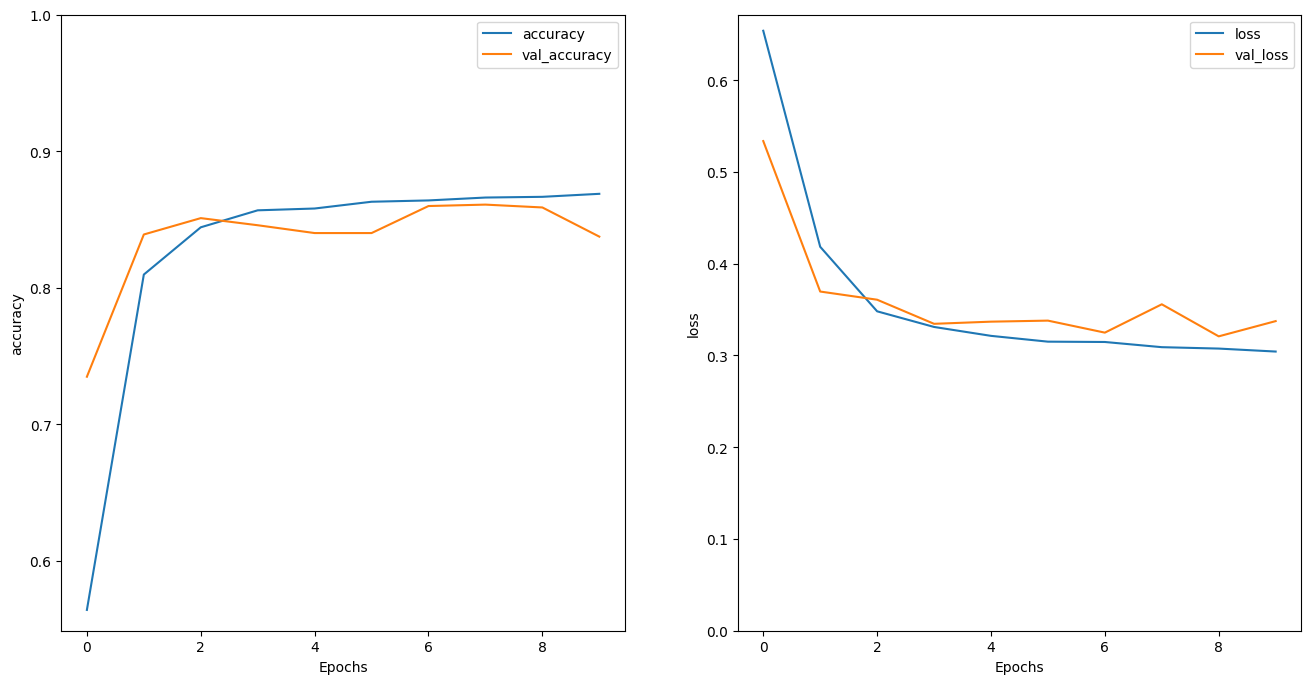

In [26]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [27]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Convert to numpy array and cast to object dtype
input_array = np.array([sample_text]).astype(object)

#predictions = model.predict(np.array([sample_text]))
predictions = model.predict(input_array)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
[0.61379254]
